# Описание проекта

**Контекст** - стажировка в отделе аналитики Яндекс.Афиши. 

**Цель** - помочь маркетологам оптимизировать маркетинговые затраты на основе данных от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

**Необходимо изучить**:
- как люди пользуются продуктом,
- когда они начинают покупать,
- сколько денег приносит каждый клиент,
- когда клиент окупается.

### Описание данных
Таблица **visits** (лог сервера с информацией о посещениях сайта):
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь


Таблица **orders** (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

Таблица **costs** (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

### План
1. [Загрузить и подготовить данные к анализу](#step1)
   
   
2. [Проанализировать продукт](#step2)
    - [Сколько людей пользуются в день, неделю, месяц?](#step2.1)
    - [Сколько сессий в день?](#step2.2)
    - [Сколько длится одна сессия?](#step2.3)
    - [Как часто люди возвращаются?](#step2.4)
    - [Вывод по продукту](#step2.5)
    

    
3. [Проанализировать продажи](#step3)
   -  [Когда люди начинают покупать?](#step3.1)
   -  [Сколько раз покупают за период?](#step3.2)
   -  [Какой средний чек?](#step3.3)
   -  [Сколько денег приносят? (LTV)](#step3.4)
   -  [Вывод по продажам](#step3.5)
   
   
   
4. [Проанализировать маркетинг](#step4)
   - [Сколько денег потратили? Всего / на каждый источник / по времени](#step4.1)
   - [Сколько стоило привлечение одного покупателя из каждого источника?](#step4.2)
   - [На сколько окупились расходы? (ROI)](#step4.3)
   - [Вывод по маркетингу](#step4.4)
   
   
   
5. [Сделать общие выводы](#step5)

# Шаг 1. Загрузка данных и подготовка их к анализу <a id="step1"></a>   

Загрузим библиотеки, затем загрузим датасеты и посмотрим на базовую информацию о них. 

In [1]:
%matplotlib inline

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#plt.style.use('seaborn-whitegrid')
sns.set_style('whitegrid')
sns.set_palette('Set2')

In [2]:
filenames = ['/datasets/visits_log.csv', '/datasets/orders_log.csv', '/datasets/costs.csv']
visits, orders, costs = [pd.read_csv(file) for file in filenames]
df_names = [visits, orders, costs]

for i in range(len(filenames)):
    filenames[i]
    df_names[i].head(10)
    df_names[i].info()

'/datasets/visits_log.csv'

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null object
End Ts       359400 non-null object
Source Id    359400 non-null int64
Start Ts     359400 non-null object
Uid          359400 non-null uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


'/datasets/orders_log.csv'

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null object
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


'/datasets/costs.csv'

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id    2542 non-null int64
dt           2542 non-null object
costs        2542 non-null float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


Мы загрузили три таблицы - visits, orders и costs с информацией о посетителях сайта, его покупателях и затратах на маркетинг. 

Предварительный взгляд на данные показывает, что они чистые, пропущенных значений нет, но необходимо:
- переименовать названия столбцов для удобной работы с ними, 
- привести даты к типу datetime,
- привести uid к типу object, чтобы на них не выводилась статистика,
- в visits проверить, что значения столбца device находятся в одном регистре, и привести столбец Device к типу category,
- в visits проверить, нет ли сессий, где время окончания раньше времени ее начала. Если есть, удалить или как-то преобразовать строки,
- проверить на дубликаты.

### Обработка таблицы visits

In [3]:
visits.columns = ['device', 'session_end', 'source_id', 'session_start', 'uid']
visits['uid'] = visits['uid'].astype('object')

visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])

visits.query('session_end < session_start')

,device,session_end,source_id,session_start,uid
4181,desktop,2018-03-25 03:18:00,3,2018-03-25 03:50:00,13092152539246794986
177972,desktop,2018-03-25 03:09:00,9,2018-03-25 03:55:00,4621202742905035453


Есть только две строки, где время сессий записалось неправильно (конец сессии раньше ее начала). Удалим их, чтобы они не оказывали влияние на статистику по сессиям дальше.

In [4]:
index_drop = visits.index[visits.session_end < visits.session_start]
visits = visits.drop(index_drop)

Теперь проверим значения столбца device и переведем его в категорию.

In [5]:
visits.device.unique()
visits['device'] = visits['device'].astype('category')

array(['touch', 'desktop'], dtype=object)

In [6]:
visits.duplicated().sum()
visits.info()

0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359398 entries, 0 to 359399
Data columns (total 5 columns):
device           359398 non-null category
session_end      359398 non-null datetime64[ns]
source_id        359398 non-null int64
session_start    359398 non-null datetime64[ns]
uid              359398 non-null object
dtypes: category(1), datetime64[ns](2), int64(1), object(1)
memory usage: 14.1+ MB


### Обработка таблицы orders

In [7]:
orders.columns = ['order_date', 'revenue', 'uid']
orders['uid'] = orders['uid'].astype('object')
orders['order_date'] = pd.to_datetime(orders['order_date'])

orders.duplicated().sum()
orders.info()

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
order_date    50415 non-null datetime64[ns]
revenue       50415 non-null float64
uid           50415 non-null object
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 1.2+ MB


### Обработка таблицы costs

In [8]:
costs.columns = ['source_id', 'cost_date', 'cost_amount']

costs['cost_date'] = pd.to_datetime(costs['cost_date'])

costs.duplicated().sum()
costs.info()

0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
source_id      2542 non-null int64
cost_date      2542 non-null datetime64[ns]
cost_amount    2542 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Проверим, что периоды соответствуют друг другу в трех таблицах.

In [9]:
visits.session_start.describe()
orders.order_date.describe()
costs.cost_date.describe()

count                  359398
unique                 224301
top       2017-11-24 16:06:00
freq                       19
first     2017-06-01 00:01:00
last      2018-05-31 23:59:00
Name: session_start, dtype: object

count                   50415
unique                  45991
top       2018-05-31 10:13:00
freq                        9
first     2017-06-01 00:10:00
last      2018-06-01 00:02:00
Name: order_date, dtype: object

count                    2542
unique                    364
top       2018-03-03 00:00:00
freq                        7
first     2017-06-01 00:00:00
last      2018-05-31 00:00:00
Name: cost_date, dtype: object

Создадим функции для построения графиков - pie, line, heatmap, которые будем использовать дальше для анализа.

In [10]:
def plot_pie(data, title, autopct='%.0f%%', figsize=(4, 4)):
    _ = data.plot(kind='pie', autopct=autopct, figsize=figsize, subplots=True)
    _ = plt.title(title, fontsize=14)
    _ = plt.ylabel('')
    plt.show()


def plot_line(data, title=None, label=None, figsize=(15, 5)):
    _ = data.plot(label=label, figsize=figsize)
    _ = plt.title(title, fontsize=14)
    _ = plt.legend()


def plot_heatmap(data, title, vmax, fmt='g'):
    _ = plt.figure(figsize=(15, 6))
    _ = plt.title(title, fontsize=14)
    ax = sns.heatmap(data, annot=True, fmt=fmt, linewidths=0.4, cmap='YlGn', vmax=vmax)
    _ = ax.set_yticklabels(data.index.strftime('%Y-%m-%d'))
    plt.show()

**Итого**

В таблицах тип дат изменен на datetime, названия столбцов переименованы. Дубликаты в таблицах не обнаружены. Диапазон дат расходов совпадает с датами заказов и посещений.

# Шаг 2. Продукт <a id="step2"></a>

Выделим дату сессии, неделю, месяц и год в отдельные столбцы. Также создадим столбец с  длительностью сессий в секундах.

In [11]:
visits['session_date'] = visits['session_start'].dt.date
visits['session_week'] = visits['session_start'].astype('datetime64[W]')
visits['session_month'] = visits['session_start'].astype('datetime64[M]')
visits['session_year'] = visits['session_start'].astype('datetime64[Y]')
visits['session_duration'] = (visits.session_end - visits.session_start)/ np.timedelta64(1,'s')
visits.head()

,device,session_end,source_id,session_start,uid,session_date,session_week,session_month,session_year,session_duration
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062,2017-12-20,2017-12-14,2017-12-01,2017-01-01,1080.0
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740,2018-02-19,2018-02-15,2018-02-01,2018-01-01,1680.0
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527,2017-07-01,2017-06-29,2017-07-01,2017-01-01,0.0
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214,2018-05-20,2018-05-17,2018-05-01,2018-01-01,1440.0
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168,2017-12-27,2017-12-21,2017-12-01,2017-01-01,0.0


## Сколько людей пользуются в день, неделю, месяц? <a id="step2.1"></a> 

Рассчитаем **среднее количество уникальных посетителей** в день, неделю и месяц. 

In [12]:
dau = visits.groupby(['session_date']).agg({'uid':'nunique'}).mean()
print('Среднее количество посетителей в день: ', int(dau))

wau = visits.groupby(['session_year', 'session_week']).agg({'uid':'nunique'}).mean()
print('Среднее количество уникальных посетителей в неделю:', int(wau))

mau = visits.groupby(['session_year', 'session_month']).agg({'uid':'nunique'}).mean()
print('Среднее количество уникальных посетителей в месяц:', int(mau))

Среднее количество посетителей в день:  907
Среднее количество уникальных посетителей в неделю: 5621
Среднее количество уникальных посетителей в месяц: 23228


Создадим функцию, которая будет строить сводные таблицы. Используем ее для определения среднего количества посетителей в день, неделю и месяц с разных устройств и из разных рекламных источников.

**По устройствам**

In [13]:
def plot_users_per_period(date_col, grouping_col):
    grouping = visits.pivot_table(index=date_col, columns=grouping_col, values='uid', aggfunc='nunique')
    return grouping

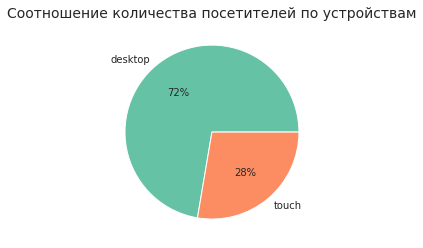

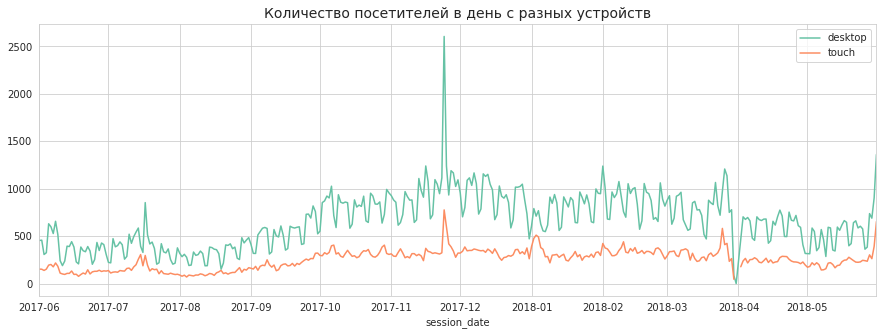

Среднее:


device
desktop    659
touch      252
dtype: int64

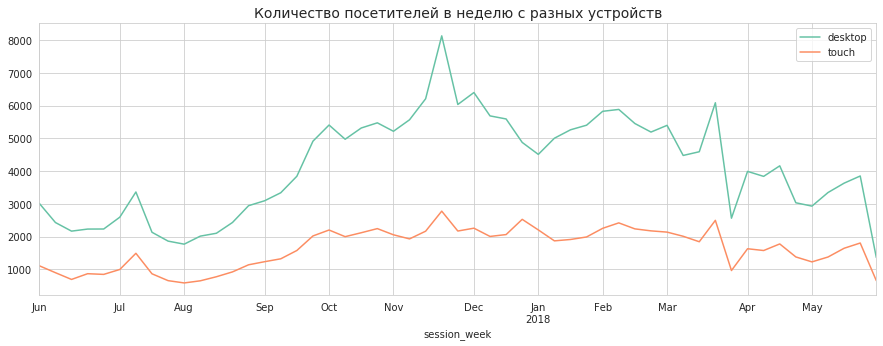

Среднее:


device
desktop    4135
touch      1637
dtype: int64

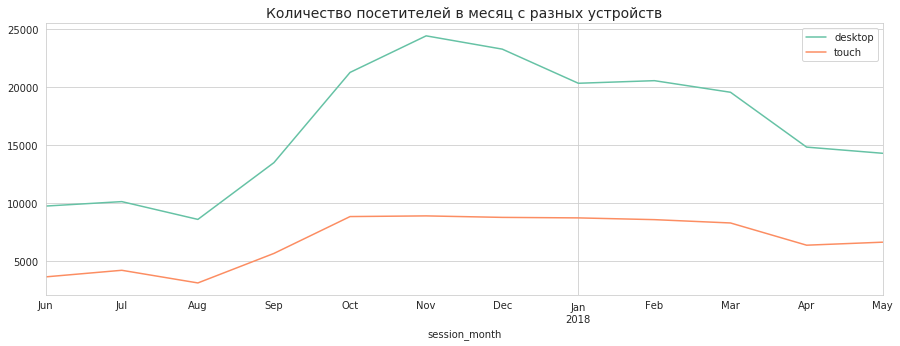

Среднее:


device
desktop    16724
touch       6825
dtype: int64

In [14]:
daily_by_device = plot_users_per_period('session_date', 'device')
plot_pie(daily_by_device.mean(axis=0).astype('int'), 'Соотношение количества посетителей по устройствам')
plot_line(daily_by_device, 'Количество посетителей в день с разных устройств')
plt.show()
print('Среднее:')
daily_by_device.mean(axis=0).astype('int')

weekly_by_device = plot_users_per_period('session_week', 'device')
plot_line(weekly_by_device, 'Количество посетителей в неделю с разных устройств')
plt.show()
print('Среднее:')
weekly_by_device.mean(axis=0).astype('int')

monthly_by_device = plot_users_per_period('session_month', 'device')
plot_line(monthly_by_device, 'Количество посетителей в месяц с разных устройств')
plt.show()
print('Среднее:')
monthly_by_device.mean(axis=0).astype('int')

Среднее количество посетителей в день:  907, в неделю: 5621, в месяц: 23228. 

Из них **на посетителей, использующих компьютер, приходится 71%, а с мобильных устройств - 29%**. Можно предположить, что с компьютера удобнее смотреть схему расположения мест в зале и выбирать подходящие. На дневном графике хорошо виден пик посетителей в конце декабря 2017 (больше 2500 посетителей с декстопа), и провал в конце марта 2018 - вероятно, произошел технический сбой (почти 0 посетителей). 

Интересно заметить, что с мобильных устройств количество посетителей примерно одинаково с октября по март, а с компьютера виден небольшой пик в начале ноября, дальше примерно одинаковое количество посетителей с января до марта и потом спад к апрелю. Можно предположить, что это связанно с театральным сезоном  - летом наблюдается спад с небольшим всплеском в первой трети июля (вероятно, интерес к сайту связан с большим количеством фестивалей, проходивших в это время - https://chips--journal-ru.turbopages.org/s/chips-journal.ru/reviews/festivali-leta-2017), с сентября посетителей становится больше (начинается театральный сезон), пик приходится на ноябрь (подготовка к новогодним праздникам), высокий спрос с января по март и дальше начинается постепенный спад к лету. 

**По рекламным каналам**

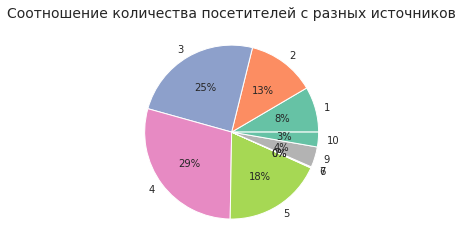

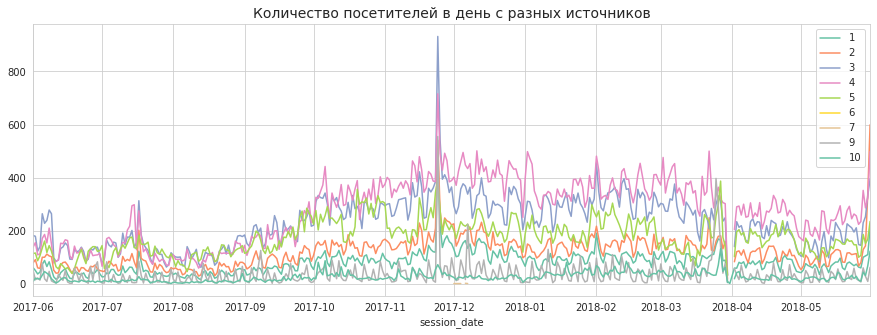

Среднее:


source_id
1      80
2     120
3     232
4     275
5     175
6       1
7       1
9      36
10     26
dtype: int64

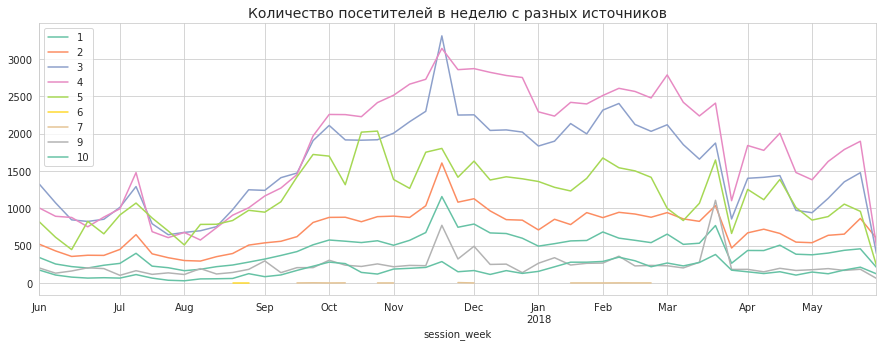

Среднее:


source_id
1      464
2      716
3     1565
4     1830
5     1168
6        1
7        1
9      238
10     166
dtype: int64

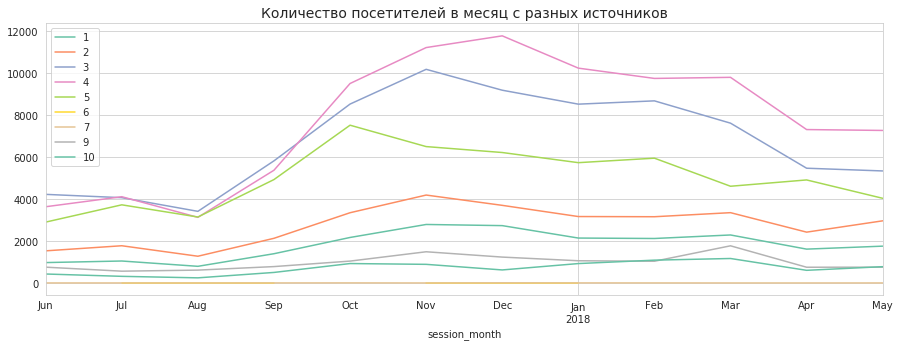

Среднее:


source_id
1     1818
2     2752
3     6758
4     7765
5     5017
6        1
7        2
9      987
10     707
dtype: int64

In [15]:
daily_by_source = plot_users_per_period('session_date', 'source_id')
plot_pie(daily_by_source.mean(axis=0).astype('int'), 'Соотношение количества посетителей с разных источников')
plot_line(daily_by_source, 'Количество посетителей в день с разных источников')
plt.show()
print('Среднее:')
daily_by_source.mean(axis=0).astype('int')

weekly_by_source = plot_users_per_period('session_week', 'source_id')
plot_line(weekly_by_source, 'Количество посетителей в неделю с разных источников')
plt.show()
print('Среднее:')
weekly_by_source.mean(axis=0).astype('int')

monthly_by_source = plot_users_per_period('session_month', 'source_id')
plot_line(monthly_by_source, 'Количество посетителей в месяц с разных источников')
plt.show()
print('Среднее:')
monthly_by_source.mean(axis=0).astype('int')

Графики показывают, что **большее количество посетителей приходит с рекламных источников 4 (30%), 3 (26%) и 5 (19%), а наименьшее - с 10 (3%) и 9 (4%)** (с источников 6 и 7 - в среднем по 1-2 пользователя в месяц, их можно не принимать во внимание). В целом, пропорциональность сохраняется между различными источниками (от дня к неделе к месяцу). 

С июня по сентябрь 2017 год 3й источник приносил примерно столько посетителей, как и 4й, но с сентября 4й начинает лидировать и так и держит свою позицию по май 2018. Интересно заметить, что 5й источник иногда дает пики там, где два лидирующих, наоборот, приносят меньше посетителей (например, в середине июня 2017, во второй половине октября 2017, в начале декабря 2017). Возможно, на нем была опробована несколько другая стратегия. 

## Сколько сессий в день? <a id="step2.2"></a> 

Посчитаем **количество сессий в среднем** не учитывая разделение по устройствам или рекламным каналам. 

Сделаем **группировку по дате** и построим гистограмму, чтобы посмотреть распределение. В зависимости от него выберем и посчитаем меры центральной тенденции. 

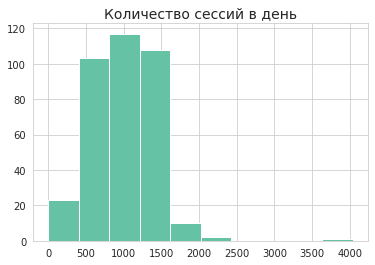

In [16]:
sessions_by_date = visits.groupby('session_date')['uid'].count()
_ = sessions_by_date.hist()
_ = plt.title('Количество сессий в день', fontsize=14)

Распределение похоже на нормальное, если не принимать во внимание выбросы (больше 3500 сессий в день). **Посчитаем медиану**.

In [17]:
sessions_by_date.median()

1003.0

Медиана (**1003 сессии в день**) превышает превышает количество посетителей (907), которое мы посчитали раннее (dau), что означает, некоторые приходят на сайт несколько раз в день, но таких немного. 

Посчитаем **количество сессий в день на посетителя**.

In [18]:
sessions_by_user = visits.groupby('uid')[['session_date']].count()
sessions_by_user.describe(percentiles=[.8, .9, .95, .99, 0.995, .999]).T

,count,mean,std,min,50%,80%,90%,95%,99%,99.5%,99.9%,max
session_date,228169.0,1.575139,4.646787,1.0,1.0,2.0,2.0,3.0,8.0,11.0,35.0,893.0


Статитика показывает, что 80% пользователей оставляют не более 2х сессий в день, при этом есть выброс на 893 сессии, который значительно смещает среднее. В данном случае можно взять моду.

In [19]:
sessions_by_user.mode()

,session_date
0,1


In [20]:
sessions_by_user[sessions_by_user.session_date > 35].sort_values(by='session_date').head()
sessions_by_user[sessions_by_user.session_date > 35].sort_values(by='session_date').tail()

,session_date
uid,
2038282660442686915,36
1270783073996707124,36
12151135467239168725,36
15589110502033756874,36
6361441887363288344,37


,session_date
uid,
8056418121947262981,343
17030528792926543083,357
11255648391090536411,551
3263486045884611639,615
12869801667763685675,893


Мода подтвержает, что **в среднем на одного пользователя приходится одна сессия в день**.  Интересно, что есть 0.1% посетителей, который проводят более 35 сессий в день на сайте - вплоть до  893! Возможно, часть этих посетителей как-то работают с сайтом, а часть этих данных - технические ошибки или боты, так как маловероятно, что кто-то будет заходить на сайт каждые 15 мин в течение суток (893 сессии). 

Теперь посмотрим сессии по устройствам и рекламным источникам.

Сделаем функцию для создания сводной таблицы, просмотра ее статистики и построения графиков.

In [21]:
def plot_sessions(date_col, grouping_col, title):
    sessions = visits.pivot_table(index=date_col, columns=grouping_col, values='uid', aggfunc='count')
    _ = plt.figure(figsize=(13,6))
    _ = plt.title(title, fontsize=14)
    _ = sns.boxplot(data = sessions, orient='h', saturation=0.9, width=0.4)
    plt.show()
    return sessions.describe().T

Посчитаем **сессии по разным устройствам**

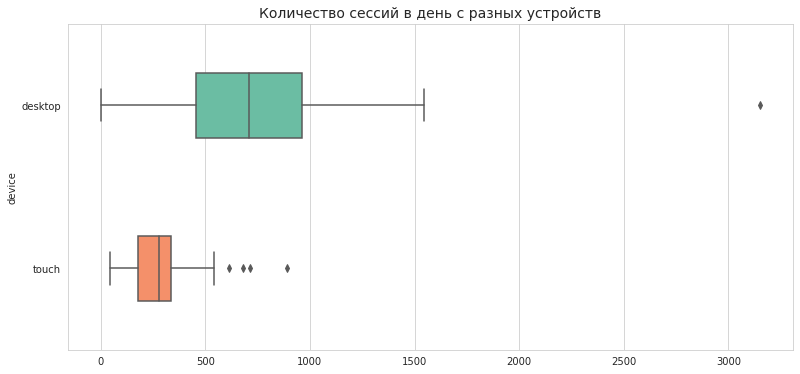

,count,mean,std,min,25%,50%,75%,max
device,,,,,,,,
desktop,364.0,721.332418,322.321413,1.0,457.25,711.0,961.5,3152.0
touch,363.0,266.757576,110.862623,47.0,181.00,278.0,337.0,890.0


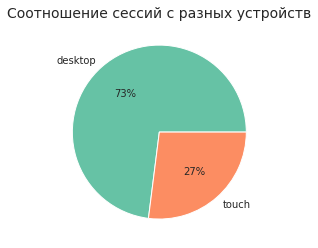

In [22]:
sessions_by_device = plot_sessions('session_date', 'device', 'Количество сессий в день с разных устройств')
sessions_by_device
plot_pie(sessions_by_device['mean'], 'Соотношение сессий с разных устройств')

График показывает, что **с компьютера сессий примерно в 2,7 раз больше (среднее - 721, медиана - 711), чем с мобильных устройств (среднее - 266, медиана - 278)**. Также видно, что c десктопа в один день случилось больше 3000 сессий (выброс на графике), из-за чего среднее значение сдвигается и становится больше медианы, а у touch - наоборот, медиана выше среднего, что означает большое количество дней с небольшим количеством сессий. 

Процентное соотношение согласуется с полученным выше по количеству уникальных пользователей с разных устройств (примерно 70% с десктопа против 30% с мобильных устройств).

Посчитаем **сессии по разным источникам**

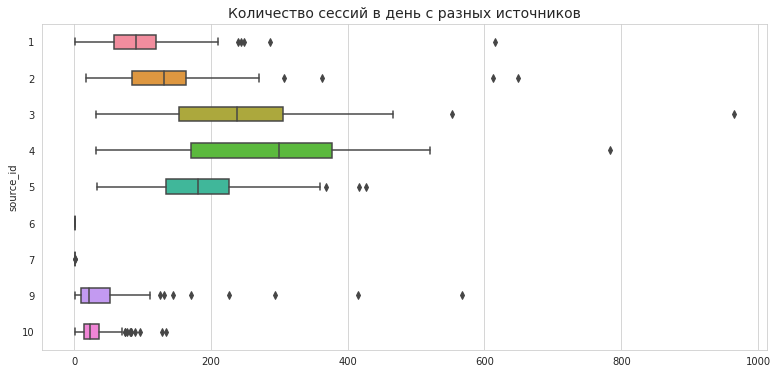

,count,mean,std,min,25%,50%,75%,max
source_id,,,,,,,,
1,364.0,93.739011,51.809680,1.0,59.0,91.0,120.0,615.0
2,363.0,131.201102,65.523610,18.0,84.5,131.0,163.5,649.0
3,363.0,235.837466,98.624454,32.0,154.0,238.0,305.0,965.0
4,363.0,280.424242,124.095297,32.0,171.5,300.0,376.5,783.0
5,363.0,184.311295,68.697387,33.0,134.5,181.0,227.0,427.0
6,6.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
7,34.0,1.058824,0.238833,1.0,1.0,1.0,1.0,2.0
9,363.0,36.573003,47.907508,1.0,9.5,22.0,52.5,567.0
10,363.0,27.617080,19.365329,1.0,14.0,23.0,37.0,135.0


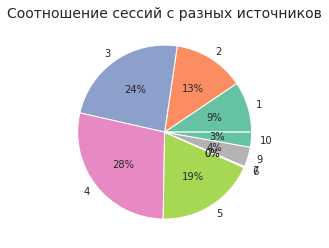

In [23]:
sessions_by_source = plot_sessions('session_date', 'source_id', 'Количество сессий в день с разных источников')
sessions_by_source
plot_pie(sessions_by_source['mean'], 'Соотношение сессий с разных источников')

Сделаем срез по источнику 3, где больше 400 сессий (потому что там уже только усы и выбросы), чтобы лучше посмотреть на выбросы. 

In [24]:
sessions_by_source_full = visits.pivot_table(index='session_date', columns='source_id', values='uid', aggfunc='count')
sessions_by_source_full[sessions_by_source_full[3] > 400]

source_id,1,2,3,4,5,6,7,9,10
session_date,,,,,,,,,
2017-11-16,154.0,247.0,426.0,487.0,340.0,NaN,NaN,40.0,63.0
2017-11-24,615.0,612.0,965.0,783.0,417.0,NaN,NaN,567.0,83.0
2017-11-25,286.0,307.0,552.0,520.0,289.0,NaN,NaN,70.0,65.0
2017-11-27,208.0,271.0,416.0,507.0,255.0,NaN,NaN,68.0,49.0
2017-11-28,249.0,270.0,403.0,481.0,239.0,NaN,NaN,69.0,35.0
2017-12-13,194.0,248.0,403.0,482.0,283.0,NaN,NaN,40.0,20.0
2018-02-01,240.0,243.0,466.0,495.0,263.0,NaN,NaN,97.0,74.0
2018-02-13,142.0,170.0,404.0,446.0,185.0,NaN,NaN,60.0,46.0
2018-05-31,244.0,649.0,409.0,509.0,253.0,NaN,1.0,62.0,129.0


График показывает, что **к наибольшему количеству сессий приводят рекламные источники 4, 3 и 5**. При этом:
- у источников **3 и 5** среднее и медиана примерно одинаковы (**235/238 и 184/181 соответственно** сессий в день)
- у 4го - медиана (280) ниже среднего (300), несмотря на два выброса, что указывает на большее количество дней с меньшим количеством сессий.

Интересна природа выбросов. Срез на количество сессий источника 3 больше 400 показывает, что, например, 24.11.17 и 31.05.18 со всех источников было гораздо больше сессий, чем в среднем. Возможно, это была какая-то особая рекламная кампания или технический сбой. 

**Наименее эффективны - 1й, 9й и 10й** 

Процентное соотношение согласуется с полученным выше по количеству уникальных пользователей с разных рекламных источников (30% - 4й, 25%-3й, 19%-5й).

## Сколько длится одна сессия? <a id="step2.3"></a> 

Посчитаем длительность одной сессии в среднем, а потом детализируем по устройствам и по рекламным источникам

,count,mean,std,min,50%,80%,90%,95%,99%,max
session_duration,359398.0,643.042287,997.105212,0.0,300.0,1020.0,1620.0,2280.0,4500.0,42660.0


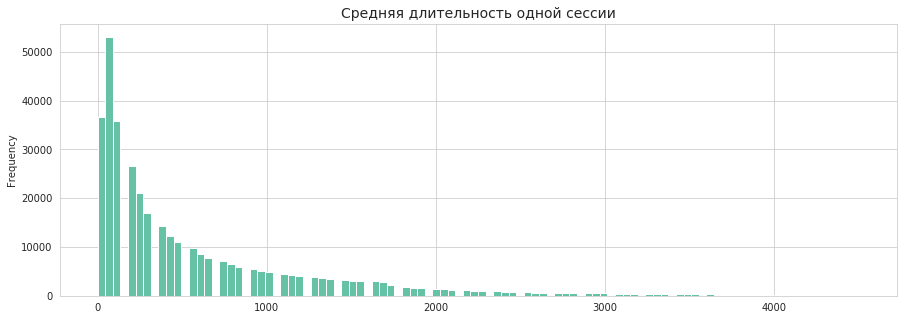

In [25]:
visits[['session_duration']].describe(percentiles=[.8, .9, .95, .99]).T
_ = visits['session_duration'].plot(kind='hist', bins=100, range=(0, 4500), figsize=(15,5))
_ = plt.title('Средняя длительность одной сессии', fontsize=14)

Гистограмма и статистика показывают, что 95% сессий не дольше 2300 сек (около 38 минут), при этом максимальная длительность сессии = 42669 сек (почти 12 часов), что сильно смещает среднее. Соответственно, необходимо смотреть на **медиану, равную 300 сек (5 мин)**, что и надо выбрать средней мерой. При построении графиков по устройствам и рекламным источникам ограничим значения до 4500 сек (что покажет 99% данных).

**По устройствам**

,count,mean,std,min,50%,80%,90%,95%,99%,99.5%,99.9%,max
device,,,,,,,,,,,,
desktop,262565.0,703.312041,1067.030043,0.0,360.0,1140.0,1740.0,2520.0,4860.0,6180.0,10440.00,42660.0
touch,96833.0,479.619407,752.531533,0.0,180.0,780.0,1320.0,1740.0,3240.0,4140.0,7090.08,30840.0


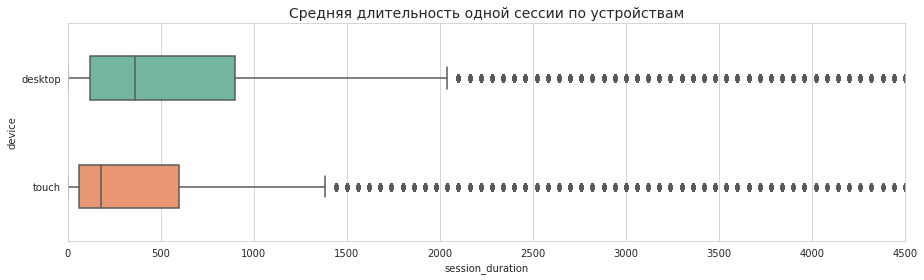

In [26]:
visits.groupby('device')['session_duration'].describe(percentiles=[.8, .9, .95, .99, 0.995, .999])
_ = plt.figure(figsize=(15,4))
g = sns.boxplot(data=visits, x='session_duration', y='device', orient='h', width=0.4)
_ = g.set(xlim=(0, 4500))
_ = plt.title('Средняя длительность одной сессии по устройствам', fontsize=14)

График показывает, что **с компьютеров пользователи сидят почти в два раза дольше, чем с мобильных устройств (6 мин против 3 мин по медиане)**. При этом 99% посетителей с компьютера сидят не дольше 1 часа 20 мин, а в мобильных устройств - не более 55 мин. 

**По рекламным источникам**

,count,mean,std,min,50%,80%,90%,95%,99%,99.5%,99.9%,max
source_id,,,,,,,,,,,,
1,34121.0,1039.361156,1463.041062,0.0,600.0,1620.0,2460.0,3540.0,6660.0,8520.0,14280.00,35760.0
2,47626.0,844.717318,1386.775652,0.0,420.0,1320.0,1980.0,3000.0,6360.0,8580.0,15022.50,31440.0
3,85609.0,572.303590,848.638934,0.0,240.0,900.0,1500.0,2100.0,3840.0,4860.0,7800.00,42660.0
4,101794.0,559.841042,793.031810,0.0,240.0,900.0,1500.0,1980.0,3720.0,4560.0,6852.42,22860.0
5,66905.0,526.742187,755.123075,0.0,240.0,840.0,1380.0,1860.0,3540.0,4380.0,6545.76,18360.0
6,6.0,1370.000000,2280.447325,0.0,420.0,1260.0,3600.0,4770.0,5706.0,5823.0,5916.60,5940.0
7,36.0,606.666667,966.277097,0.0,180.0,1080.0,1290.0,1755.0,4188.0,4734.0,5170.80,5280.0
9,13276.0,566.286532,816.950895,0.0,240.0,900.0,1500.0,2040.0,3900.0,4860.0,7570.50,10680.0
10,10025.0,662.443890,1025.266795,0.0,300.0,1080.0,1620.0,2340.0,4725.6,6180.0,11271.36,15240.0


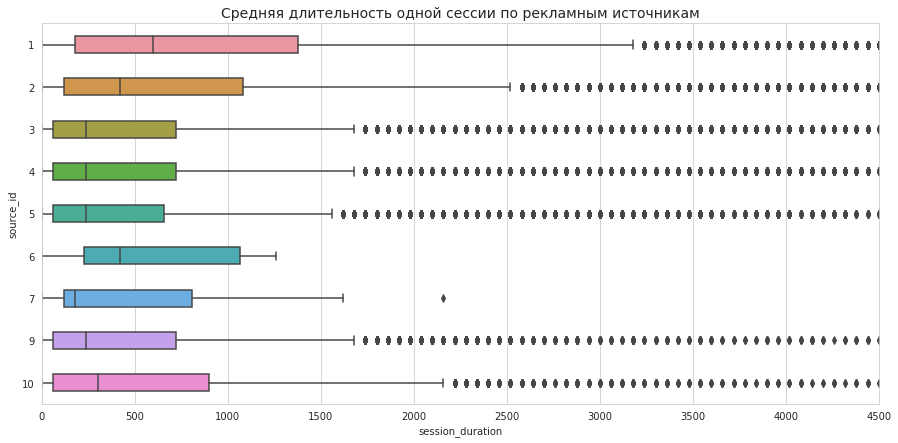

In [27]:
visits.groupby('source_id')['session_duration'].describe(percentiles=[.8, .9, .95, .99, 0.995, .999])
_ = plt.figure(figsize=(15,7))
g = sns.boxplot(data=visits, x='session_duration', y='source_id', orient='h', width=0.4)
_ = g.set(xlim=(0, 4500))
_ = plt.title('Средняя длительность одной сессии по рекламным источникам', fontsize=14)

Интересно отметить, что **лидирует** по продолжительности сессии **1й источник**, который только 5й по количеству сессий, - посетители задерживаются в среднем на **10 минут**. После него идет 2й источник - 7 мин. **Источники, которые привлекают больше всего посетителей (4, 3, 5), приводят к более короткой сессии (5 мин против 6ти по медиане)** - в целом находятся на 4м месте по длительности сессии (если не брать в расчет 6й источник, с которого было всего 6 сессий за год). Самая короткая сессия - у 7го источника, который также принес очень мало посетителей (3 мин).

## Как часто люди возвращаются? <a id="step2.4"></a> 

Для определения того, как часто возвращаются посетители, сначала добавим в таблицу visits столбцы с датой первой сессии на пользователя (first_visit), выделим из нее месяц (first_visit_month) и посчитаем длительность жизни каждой когорты (cohort_lifetime). 

In [28]:
first_visit = visits.groupby('uid')['session_start'].min()
first_visit.name = 'first_visit'
visits = visits.join(first_visit, on='uid')
visits['first_visit_month'] = visits['first_visit'].astype('datetime64[M]')
visits['cohort_lifetime'] = (visits.session_month - visits.first_visit_month)  / np.timedelta64(1,'M')
visits['cohort_lifetime'] = visits['cohort_lifetime'].round().astype('int')

Теперь сделаем функцию для создания сводных таблиц с когортами и их Retention Rate, чтобы применить ее для всех данных, а потом с разбивкой по устройствам и рекламным источникам. 
Построим одну тепловую карту по всем данным для общей картины и линейные графики для сравнения коэфициента удержания для устройств и источников. Возьмем для сравнения только 5 первых источников, так как по 6, 7, 9 и 10 очень мало данных.

Для среднего значения выведем Retention Rate по 1му месяцу жизни когорты. 

In [29]:
def count_rr(df):
    cohorts = df.groupby(['first_visit_month', 'cohort_lifetime']).agg({'uid': 'nunique'}).reset_index()
    initial_user_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_visit_month','uid']]
    initial_user_count = initial_user_count.rename(columns={'uid':'cohort_users'})
    cohorts = cohorts.merge(initial_user_count,on='first_visit_month')
    cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']
    retention = cohorts.pivot_table(index='first_visit_month', columns='cohort_lifetime', values='retention', aggfunc='sum')
    return retention

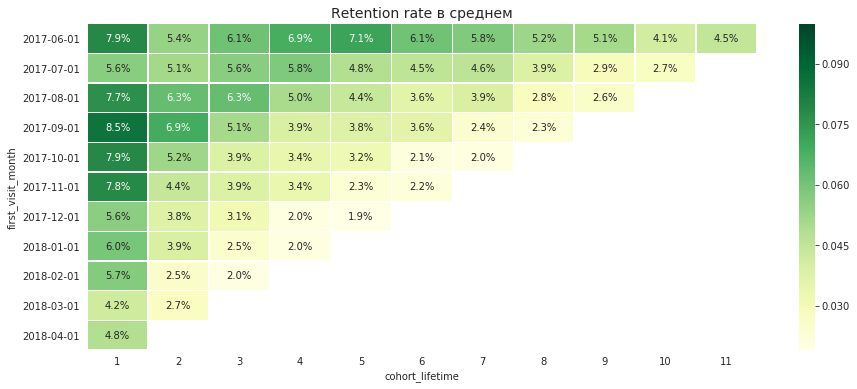

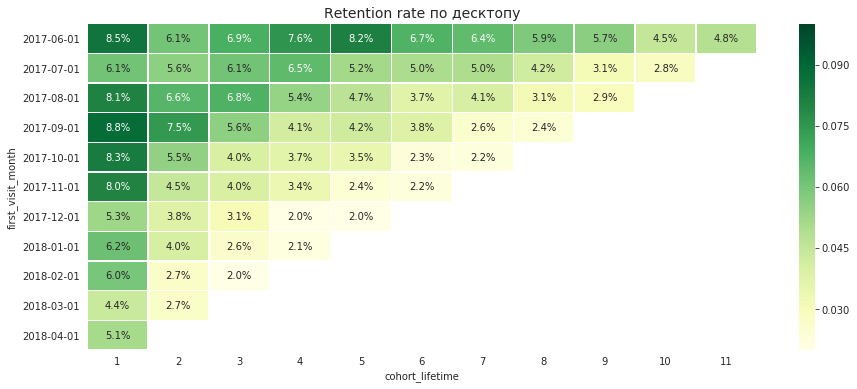

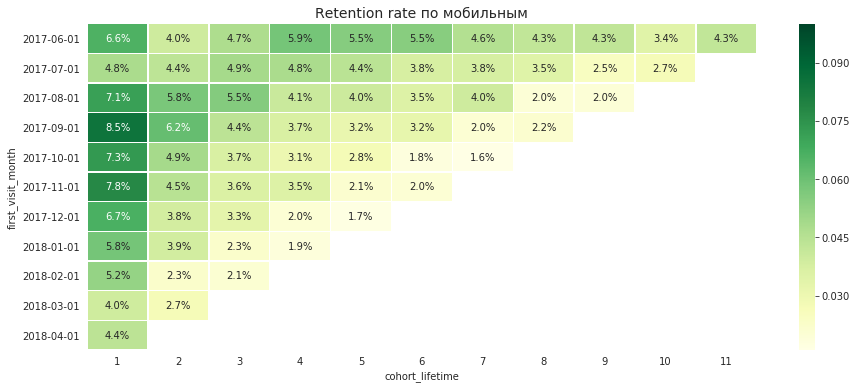

In [30]:
rr_total = count_rr(visits)
plot_heatmap(rr_total.iloc[:-1, 1:], 'Retention rate в среднем', vmax=0.1, fmt='.1%')

rr_desktop = count_rr(visits.query('device=="desktop"'))
plot_heatmap(rr_desktop.iloc[:-1, 1:], 'Retention rate по десктопу', vmax=0.1, fmt='.1%')

rr_touch = count_rr(visits.query('device=="touch"'))
plot_heatmap(rr_touch.iloc[:-1, 1:], 'Retention rate по мобильным', vmax=0.1, fmt='.1%')

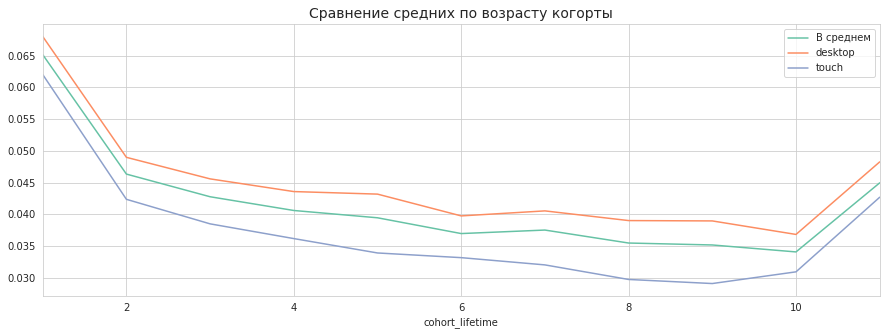

In [31]:
plot_line(rr_total.iloc[:, 1:].mean(axis=0), label='В среднем')
plot_line(rr_desktop.iloc[:, 1:].mean(axis=0), label='desktop')
plot_line(rr_touch.iloc[:, 1:].mean(axis=0), 'Сравнение средних по возрасту когорты', label='touch')
_ = plt.legend()

Графики показывают, что в среднем коэффициент удержания пользователей составляет 6.5% на 1м месяце жизни когорты и затем падает до примерно 3.7% на 8м, при этом у декстопа он стабильно выше, чем у мобильных устройств.

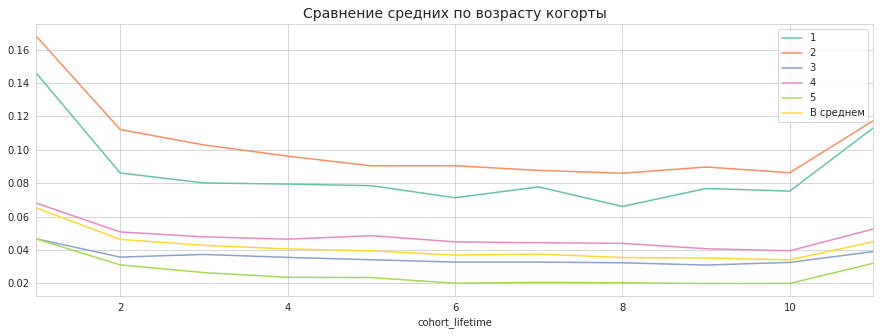

In [32]:
for i in range (1, 6):
    rr = count_rr(visits.query('source_id  == @i'))
    plot_line(rr.iloc[:, 1:].mean(axis=0), label=i)
    
plot_line(rr_total.iloc[:, 1:].mean(axis=0), 'Сравнение средних по возрасту когорты', label='В среднем')
_ = plt.legend()

Линейные графики показывают, что коэффициент удержания пользователей выше у тех, кто пришел с 2го (16.7%) и 1го (14.5%) источников, что выше среднего. При этом на эти источники приходится только около 11% и 7% сессий соответственно. Самый низкий Retention rate у 5го источника (4.5%), а у 3го и 4го - близко к среднему. 

## Вывод по продукту<a id="step2.5"></a>

#### Сколько посетителей в день?
Среднее количество посетителей в день:  907, в неделю: 5621, в месяц: 23228. 

Из них *на посетителей, использующих компьютер, приходится 71%, а с мобильных устройств - 29%*. Можно предположить, что с компьютера удобнее смотреть схему расположения мест в зале и выбирать подходящие. С мобильных устройств количество посетителей примерно одинаково с октября по март, а с компьютера виден небольшой пик в начале ноября, дальше примерно одинаковое количество посетителей с января до марта и потом спад к апрелю. Можно предположить, что это связанно с сезонностью

*Большее количество посетителей приходит с рекламных источников 4 (30%), 3 (26%) и 5 (19%), а наименьшее - с 10 (3%) и 9 (4%)*. В целом, пропорциональность сохраняется между различными источниками (от дня к неделе к месяцу). Интересно заметить, что 5й источник иногда дает пики там, где два лидирующих, наоборот, приносят меньше посетителей (например, в середине июня 2017, во второй половине октября 2017, в начале декабря 2017).

#### Сколько сессий в день?
В день среднем *1003 сессии, из них 73% приходится на декстоп, 27% - на мобильные устройства*. К наибольшему количеству сессий приводят рекламные источники *4, 3 и 5 - 28%, 24% и 19%* соответственно. 
На одного посетителя - в среднем одна сессия в день. 

#### Сколько длится одна сессия?
95% сессий не дольше 2300 сек (около 38 минут), при этом *медиана равна 300 сек (5 мин)*.

*С компьютеров* пользователи сидят почти *в два раза дольше, чем с мобильных устройств (6 мин против 3 мин по медиане)*. 
*Лидирует по продолжительности сессии 1й источник*, который только 5й по количеству сессий, - посетители задерживаются в среднем на 10 минут. После него идет 2й источник - 7 мин. Источники, которые привлекают больше всего посетителей (4, 3, 5), приводят к более короткой сессии (5 мин против 6ти по медиане) - в целом находятся на 4м месте по длительности сессии. 
 
#### Как часто люди возвращаются?
*В среднем коэффициент удержания пользователей составляет 6.5% на 1м месяце жизни когорты и затем падает до примерно 3.7% на 8м*, при этом *у декстопа он стабильно выше*, чем у мобильных устройств, *и у тех, кто пришел с 2го (16.7%) и 1го (14.5%) источников*, что выше среднего. При этом на эти источники приходится только около 11% и 7% сессий соответственно. 

# Шаг 3. Продажи <a id="step3"></a>

## Когда люди начинают покупать? <a id="step3.1"></a>

Создадим новые столбцы в таблице orders c датой (first_order_date) и добавим месяц первого заказа (first_order_month).

In [33]:
orders['order_month'] = orders['order_date'].astype('datetime64[M]')

first_order = orders.groupby('uid')['order_date'].min()
first_order.name = 'first_order_date'
orders = orders.join(first_order, on='uid')
orders['first_order_month'] = orders['first_order_date'].astype('datetime64[M]')

orders.head()

,order_date,revenue,uid,order_month,first_order_date,first_order_month
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01


Необходимо сравнить, когда посетители начинают покупать в принципе и если заходят с определенного устройства или источника. Таким образом, для первого визита будут разные данные во всех случаях.

Создадим функцию find_first_order, чтобы посчитать, сколько времени проходит от первого посещения до первой покупки в зависимости от необходимой группировки. Возьмем даты первой покупки у каждого пользователя в таблице orders и время первой сессии из таблицы visits, соединим в одну и создадим новые столбцы с временем от посещения до покупки в днях, часах и минутах (чтоб было удобно сравнивать). 

Применим ее сначала ко всем данным, потом посмотрим на группировки с устройствами и рекламными источниками.

In [34]:
def find_first_order(cols):
    first_session = visits.groupby(cols)['first_visit'].first().reset_index()
    first_session['uid'] = first_session['uid'].astype('object')
    
    first_order = first_session.merge(orders[['uid', 'first_order_date']].drop_duplicates(), on='uid', how='right')
    first_order['first_order_days'] = ((first_order.first_order_date - first_order.first_visit)/np.timedelta64(1, 'D')).round(2)
    first_order['first_order_hours'] = ((first_order.first_order_date - first_order.first_visit)/np.timedelta64(1, 'h')).round(2)
    first_order['first_order_minutes'] = ((first_order.first_order_date - first_order.first_visit)/np.timedelta64(1, 'm')).round(2)
    return first_order

**Все данные**

In [35]:
first_order_total = find_first_order('uid')
first_order_total.head()
first_order_total.describe(percentiles=[.6, .65, .75, .8, .9, .95, .99]).T

,uid,first_visit,first_order_date,first_order_days,first_order_hours,first_order_minutes
0,313578113262317,2017-09-18 22:49:00,2018-01-03 21:51:00,106.96,2567.03,154022.0
1,1575281904278712,2017-06-03 10:13:00,2017-06-03 10:13:00,0.00,0.00,0.0
2,2429014661409475,2017-10-11 17:14:00,2017-10-11 18:33:00,0.05,1.32,79.0
3,2464366381792757,2018-01-27 20:10:00,2018-01-28 15:54:00,0.82,19.73,1184.0
4,2551852515556206,2017-11-24 10:14:00,2017-11-24 10:14:00,0.00,0.00,0.0


,count,mean,std,min,50%,60%,65%,75%,80%,90%,95%,99%,max
first_order_days,36523.0,16.902428,47.07293,0.0,0.01,0.03,0.09,2.010,6.98,58.076,123.898,237.9002,363.29
first_order_hours,36523.0,405.669723,1129.74622,0.0,0.27,0.73,2.20,48.285,167.48,1393.880,2973.467,5709.5814,8719.07
first_order_minutes,36523.0,24340.175834,67784.77469,0.0,16.00,44.00,132.00,2897.000,10048.80,83633.000,178408.000,342574.8400,523144.00


Статистика показывает, что среднее (17 дней) и медиана (16 мин) значительно отличаются, причем очевидно, что много очень малых значений (в 60% случаев покупка происходит менее, чем за 44 мин). Посмотрим на распределение данных от 0 до 1 часа.

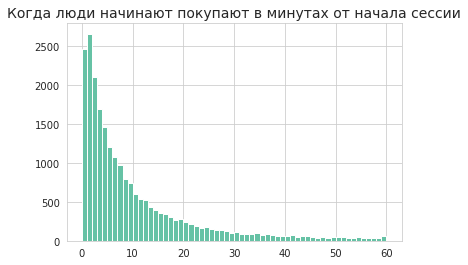

In [36]:
_ = first_order_total.first_order_minutes.hist(bins=60, range=(0, 60))
_ = plt.title('Когда люди начинают покупают в минутах от начала сессии', fontsize=14)

Гистограмма показывает распределение Пуассона. Посмотрим наиболее часто встречающиеся значения на первых 10 минутах. 

In [37]:
first_order_total['first_order_minutes'].value_counts().sort_values(ascending=False).head(10) / len(first_order_total)

1.0    0.072721
0.0    0.067218
2.0    0.057443
3.0    0.046135
4.0    0.039975
5.0    0.032966
6.0    0.029488
7.0    0.026559
8.0    0.021712
9.0    0.020316
Name: first_order_minutes, dtype: float64

Почти 6.7% покупателей совершили покупку одновременно с началом сессии (0 мин). Возможно, это технические ошибки сбора данных,  пользователи, у которых установлено анти-трекинговое расширение на браузер, или пользователи, которые не были авторизованы до покупки (например, зашли с новых устройств), соответственно, остальные их действия (кроме покупки) не собираются системой аналитики. Далее мы видим, что в 7.2% случаев покупка совершается в первую минуту сессии. 

Таким образом, **60% людей начинают покупать в течение первого часа после захода на страницу**, при этом **наиболее часто встречающееся время - через одну минуту**.

Посмотрим, какие есть отличия **по устройствам**. Очевидно, что различия наиболее ярко будут выражаться в первый час. Исходя из этого посмотрим статистику и построим гистограмму.

In [38]:
first_order_by_device = find_first_order(['uid', 'device'])
first_order_by_device.head()
first_order_by_device.groupby('device')['first_order_minutes'].describe().T

,uid,device,first_visit,first_order_date,first_order_days,first_order_hours,first_order_minutes
0,313578113262317,desktop,2017-09-18 22:49:00,2018-01-03 21:51:00,106.96,2567.03,154022.0
1,313578113262317,touch,NaT,2018-01-03 21:51:00,NaN,NaN,NaN
2,1575281904278712,desktop,NaT,2017-06-03 10:13:00,NaN,NaN,NaN
3,1575281904278712,touch,2017-06-03 10:13:00,2017-06-03 10:13:00,0.00,0.00,0.0
4,2429014661409475,desktop,2017-10-11 17:14:00,2017-10-11 18:33:00,0.05,1.32,79.0


device,desktop,touch
count,30602.000000,8912.000000
mean,25203.223940,34069.455566
std,69357.017232,77717.886912
min,0.000000,0.000000
25%,4.000000,5.000000
50%,16.000000,55.000000
75%,2914.000000,16198.000000
max,523144.000000,522287.000000


Статистика показывает, что на десктопы приходится две трети покупок. Используем логарифмическую шкалу, чтобы посмотреть, есть ли разница во времени.

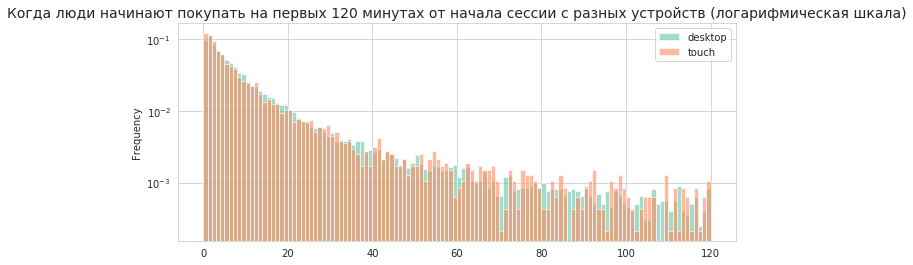

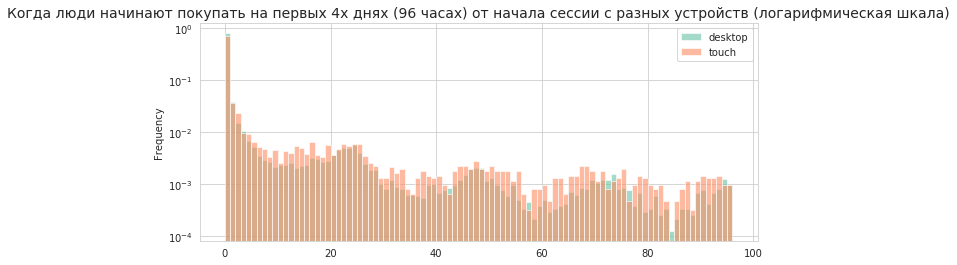

In [39]:
_ = first_order_by_device.groupby('device').first_order_minutes\
                         .plot(kind='hist', bins=120, alpha=0.6, legend=True, range=(0, 120), 
                               logy=True, density=True, figsize=(10,4))
_ = plt.title('Когда люди начинают покупать на первых 120 минутах от начала сессии с разных устройств (логарифмическая шкала)', fontsize=14)
plt.show()
_ = first_order_by_device.groupby('device').first_order_hours\
                         .plot(kind='hist', bins=96, alpha=0.6, legend=True, range=(0, 96), 
                               logy=True, density=True, figsize=(10,4))
_ = plt.title('Когда люди начинают покупать на первых 4х днях (96 часах) от начала сессии с разных устройств (логарифмическая шкала)', fontsize=14)

Нормализованная гистограмма показывает, что, **если смотреть на промежутке до часа, время покупки от первого визита примерно одинаково с десктопа и с мобильных устройств**, а если рассматривать более длительный период времени, то уже со второго часа от первого визита с мобильных устройств в среднем требуется больше времени, чтобы совершить первую покупку. Кроме того, на гистограмме десктопа видны более выраженные циклические изменения (пики), что может свидетельствовать о том, что декстопом могут пользоваться в определенное время суток, а с мобильных устройств - в разное.  

Теперь посмотрим **по источникам**. Учитывая, что на гистограмме будет сложно различить несколько источников, построим pie, чтобы посмотреть, соотношение первых заказов по источникам, и boxplot, чтобы посмотреть, насколько различаются медианы. 

,uid,source_id,first_visit,first_order_date,first_order_days,first_order_hours,first_order_minutes
0,313578113262317,2,2017-09-18 22:49:00,2018-01-03 21:51:00,106.96,2567.03,154022.0
1,1575281904278712,10,2017-06-03 10:13:00,2017-06-03 10:13:00,0.00,0.00,0.0
2,2429014661409475,3,2017-10-11 17:14:00,2017-10-11 18:33:00,0.05,1.32,79.0
3,2464366381792757,5,2018-01-27 20:10:00,2018-01-28 15:54:00,0.82,19.73,1184.0
4,2551852515556206,5,2017-11-24 10:14:00,2017-11-24 10:14:00,0.00,0.00,0.0


source_id,1,2,3,4,5,7,9,10
count,7138.000000,7305.000000,13846.000000,14253.000000,10156.000000,1.0,2793.000000,1773.000000
mean,34389.954889,41412.704586,33960.666619,32624.509156,30592.718688,52.0,51538.422485,33904.122391
std,77310.276280,85619.736067,79517.893483,76085.700357,75591.905091,NaN,94490.012456,83985.959970
min,0.000000,0.000000,0.000000,0.000000,0.000000,52.0,0.000000,0.000000
25%,7.000000,7.000000,5.000000,5.000000,4.000000,52.0,8.000000,4.000000
50%,240.000000,385.000000,32.000000,35.000000,22.500000,52.0,702.000000,24.000000
75%,19391.250000,33186.000000,12790.000000,14069.000000,8503.750000,52.0,59012.000000,8291.000000
max,523144.000000,523144.000000,515128.000000,522287.000000,522287.000000,52.0,512563.000000,514531.000000


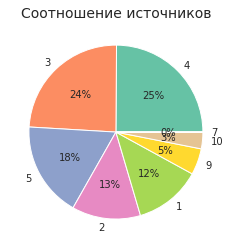

In [40]:
first_order_by_source = find_first_order(['uid', 'source_id'])
first_order_by_source.head()
first_order_by_source.groupby('source_id')['first_order_minutes'].describe().T
plot_pie(first_order_by_source.source_id.value_counts(normalize=True), 'Соотношение источников')

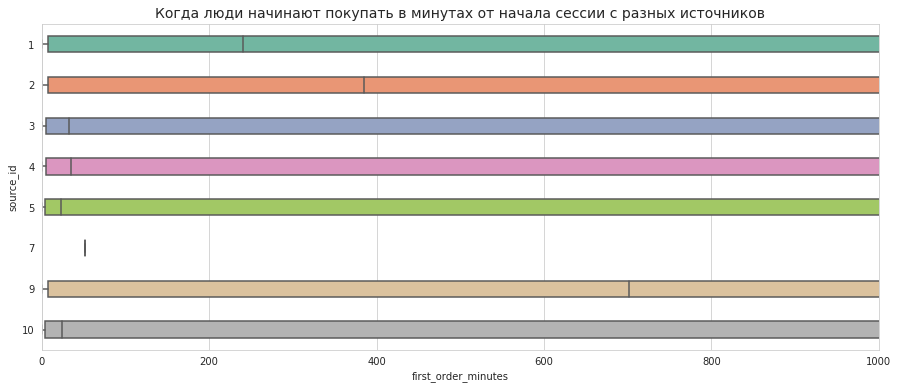

In [41]:
_ = plt.figure(figsize=(15,6))
g = sns.boxplot(data=first_order_by_source, x='first_order_minutes', y='source_id', orient='h', width=0.4)
_ = g.set(xlim=(0, 1000))
_ = plt.title('Когда люди начинают покупать в минутах от начала сессии с разных источников', fontsize=14)

График и статистика показывают, что **с источников 3, 4, 5 и 10 проходит меньше времени от первого визита до покупки (22-35 мин по медиане), а с источников 1, 2 и 9 - как минимум в 10 раз больше (240-720 мин по медиане)**. 




Теперь посчитаем, **в какую сессию посетители начинают покупать**. Добавим порядковый номер сессии.

,count,mean,std,min,50%,60%,70%,75%,80%,85%,90%,95%,max
num_of_session,28894.0,1.458296,1.363593,1.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,3.0,63.0


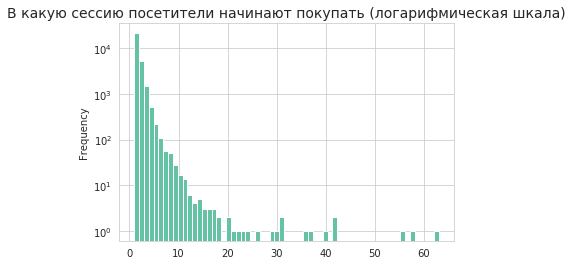

In [42]:
visits['num_of_session'] = visits.sort_values(['uid','session_start'], ascending=[True,True]).groupby(['uid']).cumcount() + 1
duration_by_sessions = visits[['uid', 'session_start', 'session_end', 'num_of_session']]\
                             .merge(orders[['uid', 'first_order_date']], on='uid')
duration_by_sessions = duration_by_sessions.query('session_start <= first_order_date <= session_end').drop_duplicates()
duration_by_sessions[['num_of_session']].describe(percentiles=[.6, .7, .75, .8, .85, .9, .95]).T
_ = duration_by_sessions.num_of_session.plot(kind='hist', bins=63, logy=True)
_ = plt.title('В какую сессию посетители начинают покупать (логарифмическая шкала)', fontsize=14)

Статистика показывают, что в **70% случаях покупка происходит на 1й сессии, а в 95% - не дольше 3й**. Судя по графику, далее количество случаев убывает по экспоненте до 15 сессии, а после 25 встречаются только отдельные пики. 

## Сколько раз покупают за период? <a id="step3.2"></a>

Так как нам необходимо сравнить данные по устройствам и по источникам, сделаем таблицу orders_with_visits, где соберем вместе данные по заказам и сессиям на каждого пользователя. Посмотрим по ней, для всех ли заказов есть сессии.

In [43]:
orders_with_visits = orders[['uid', 'order_date', 'order_month', 'revenue', 'first_order_month']]\
                           .merge(visits[['uid', 'session_start', 'session_end', 'device', 'source_id']], on='uid')
orders_with_visits = orders_with_visits.query('session_start <= order_date <= session_end')
orders_with_visits = orders_with_visits.drop(['session_start', 'session_end'], axis=1)
orders_with_visits.head()
orders_with_visits.info()

,uid,order_date,order_month,revenue,first_order_month,device,source_id
0,10329302124590727494,2017-06-01 00:10:00,2017-06-01,17.00,2017-06-01,desktop,1
1,11627257723692907447,2017-06-01 00:25:00,2017-06-01,0.55,2017-06-01,desktop,2
2,17903680561304213844,2017-06-01 00:27:00,2017-06-01,0.37,2017-06-01,desktop,2
3,16109239769442553005,2017-06-01 00:29:00,2017-06-01,0.55,2017-06-01,desktop,2
4,14200605875248379450,2017-06-01 07:58:00,2017-06-01,0.37,2017-06-01,desktop,3


<class 'pandas.core.frame.DataFrame'>
Int64Index: 35927 entries, 0 to 761806
Data columns (total 7 columns):
uid                  35927 non-null object
order_date           35927 non-null datetime64[ns]
order_month          35927 non-null datetime64[ns]
revenue              35927 non-null float64
first_order_month    35927 non-null datetime64[ns]
device               35927 non-null category
source_id            35927 non-null int64
dtypes: category(1), datetime64[ns](3), float64(1), int64(1), object(1)
memory usage: 2.0+ MB


В таблице всего 35927 строк, что говорит о том, что для 30% заказов отсутствует сессия. Это большая потеря данных. Учитывая, что, как посчитано выше, 70% покупок происходят на первой сессии, можно тогда взять информацию об устройствах и источниках на первой сессии и добавить ее в таблицу orders. И дальше будем считать количество покупок, средний чек и LTV по ней. 

In [44]:
# Эта ячейка грузится минуту или больше, я так и не поняла, почему...
first_source_device = visits.sort_values(by='session_start').groupby('uid').agg({'source_id':'first', 'device':'first'})
first_source_device.columns = ['first_source', 'first_device']
first_source_device

orders = orders.merge(first_source_device, on='uid')
orders

,first_source,first_device
uid,,
11863502262781,3,touch
49537067089222,2,touch
297729379853735,3,desktop
313578113262317,2,desktop
325320750514679,5,desktop
...,...,...
18446403737806311543,5,desktop
18446424184725333426,4,touch
18446556406699109058,3,touch


,order_date,revenue,uid,order_month,first_order_date,first_order_month,first_source,first_device
0,2017-06-01 00:10:00,17.00,10329302124590727494,2017-06-01,2017-06-01 00:10:00,2017-06-01,1,desktop
1,2017-06-01 00:25:00,0.55,11627257723692907447,2017-06-01,2017-06-01 00:25:00,2017-06-01,2,desktop
2,2017-06-01 00:27:00,0.37,17903680561304213844,2017-06-01,2017-06-01 00:27:00,2017-06-01,2,desktop
3,2017-06-01 00:29:00,0.55,16109239769442553005,2017-06-01,2017-06-01 00:29:00,2017-06-01,2,desktop
4,2017-06-01 07:58:00,0.37,14200605875248379450,2017-06-01,2017-06-01 07:58:00,2017-06-01,3,desktop
...,...,...,...,...,...,...,...,...
50410,2018-05-31 23:50:00,4.64,12296626599487328624,2018-05-01,2018-05-31 23:50:00,2018-05-01,4,touch
50411,2018-05-31 23:50:00,5.80,11369640365507475976,2018-05-01,2018-05-31 23:50:00,2018-05-01,10,desktop
50412,2018-05-31 23:54:00,0.30,1786462140797698849,2018-05-01,2018-05-31 23:54:00,2018-05-01,3,desktop
50413,2018-05-31 23:56:00,3.67,3993697860786194247,2018-05-01,2018-05-31 23:56:00,2018-05-01,3,desktop


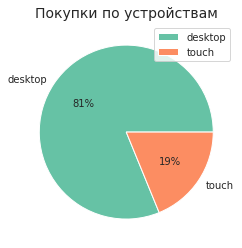

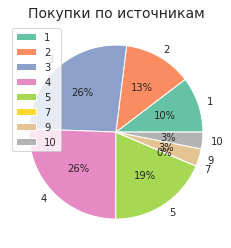

In [45]:
by_devices = pd.DataFrame(orders.first_device.value_counts(normalize=True))
plot_pie(by_devices, 'Покупки по устройствам')

by_sources = pd.DataFrame(orders.first_source.value_counts(normalize=True, sort=False))
plot_pie(by_sources, 'Покупки по источникам')

81% заказов было сделано с декстопа, 19% - с мобильных устройств. Соотношение сдвинулось на 8% в сторону декстопа по сравнению с сессиями. По источникам распределение похоже на сессии. Надо учитывать, что источник 6 в продажах не появляется.

Для вычисления числа повторных покупок и LTV нам потребуются когорты на всех данных и на срезах. Напишем функцию, где сначала найдем количество покупателей за каждый месяц (num_of_buyers) и сохраним в cohort_sizes, а потом  построим таблицу с когортами покупателей, и, наконец, добавим в нее суммарный доход (total_revenue), который потребуется дальше для рассчета LTV и CAC, и количество покупок (num_of_orders).

In [46]:
def build_cohorts(df):    
    cohort_sizes = df.groupby('first_order_month').agg({'uid': 'nunique'}).reset_index()
    cohort_sizes.columns = ['first_order_month', 'num_of_buyers']
    cohorts = df.groupby(['first_order_month', 'order_month']).agg({'revenue': 'sum', 'order_date':'count'})\
                          .reset_index()
    cohorts = cohorts.rename(columns={'revenue':'total_revenue', 'order_date':'num_of_orders'})
    cohorts = cohorts.merge(cohort_sizes, on='first_order_month')
    cohorts['cohort_lifetime'] = (cohorts.order_month - cohorts.first_order_month)  / np.timedelta64(1,'M')
    cohorts['cohort_lifetime'] = cohorts['cohort_lifetime'].round().astype('int')
    cohorts['order_per_user'] = cohorts.num_of_orders / cohorts.num_of_buyers
    return cohorts

Напишем еще одну функцию для подсчета числа повторных покупок. Фунция будет возращать сводную таблицу с накопительным количеством покупок на пользователя в когорте, на основании которых мы сможем вычислить среднее и построить графики для сравнения. Для расчета периода возьмем 6 месяцев, для которых у нас есть данные по 7 когортам (с июня по декабрь 2017).

In [47]:
def count_num_of_orders(cohorts):    
    num_of_orders = cohorts.pivot_table(index='first_order_month', columns='cohort_lifetime', values='order_per_user', 
                                                 aggfunc='sum').cumsum(axis=1).round(2)
    total = num_of_orders.iloc[:7, 5].copy()
    return num_of_orders, total

Сделаем когорты по всем данным и срезы на устройствах. Сохраним в переменных, чтобы использовать позже.

In [48]:
cohorts_total = build_cohorts(orders)
cohorts_total.head(3)
cohorts_desktop = build_cohorts(orders.query('first_device=="desktop"'))
cohorts_desktop.head(3)
cohorts_touch = build_cohorts(orders.query('first_device=="touch"'))
cohorts_touch.head(3)

,first_order_month,order_month,total_revenue,num_of_orders,num_of_buyers,cohort_lifetime,order_per_user
0,2017-06-01,2017-06-01,9557.49,2354,2023,0,1.163618
1,2017-06-01,2017-07-01,981.82,177,2023,1,0.087494
2,2017-06-01,2017-08-01,885.34,174,2023,2,0.086011


,first_order_month,order_month,total_revenue,num_of_orders,num_of_buyers,cohort_lifetime,order_per_user
0,2017-06-01,2017-06-01,8321.37,1994,1702,0,1.171563
1,2017-06-01,2017-07-01,882.43,166,1702,1,0.097532
2,2017-06-01,2017-08-01,844.70,169,1702,2,0.099295


,first_order_month,order_month,total_revenue,num_of_orders,num_of_buyers,cohort_lifetime,order_per_user
0,2017-06-01,2017-06-01,1236.12,360,321,0,1.121495
1,2017-06-01,2017-07-01,99.39,11,321,1,0.034268
2,2017-06-01,2017-08-01,40.64,5,321,2,0.015576


Посчитаем количество покупок в целом и по устройствам. Выведем тепловую карту по когортам для наглядности по всему периоду. Данные за 6 месяцев сохранятся в отдельных переменных для дальнейшего использования. 

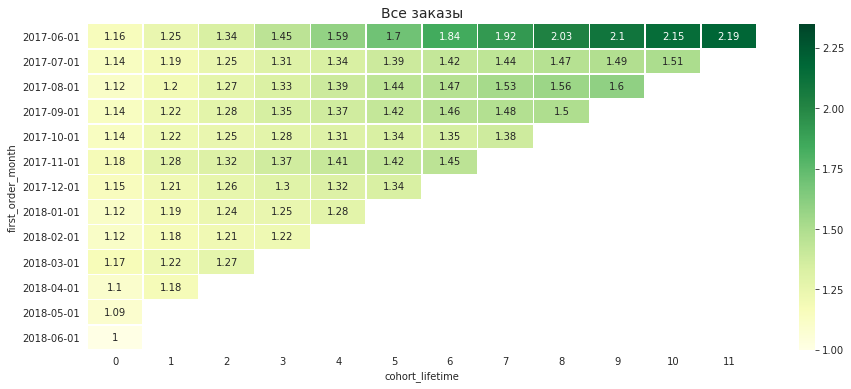

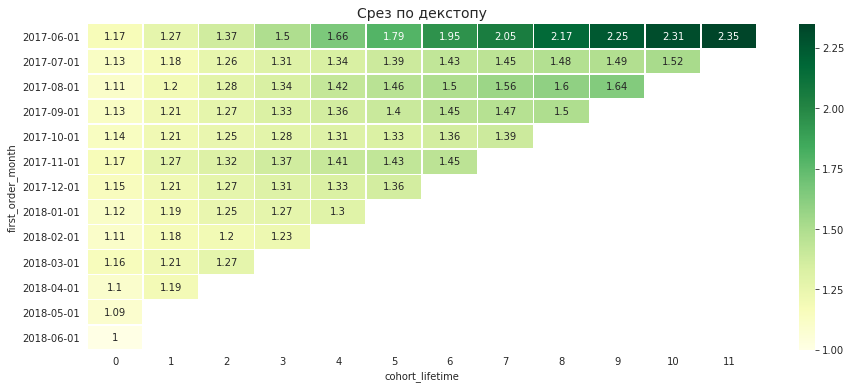

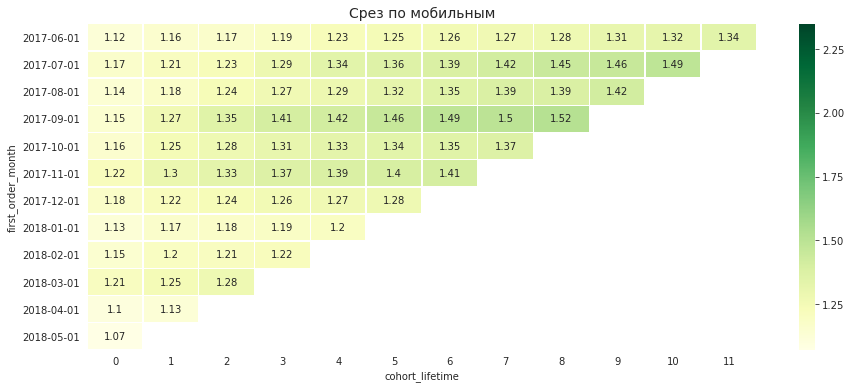

In [49]:
num_of_orders_total, num_of_orders_total_period = count_num_of_orders(cohorts_total)
plot_heatmap(num_of_orders_total, 'Все заказы', 2.35)

num_of_orders_desktop, num_of_orders_desktop_period = count_num_of_orders(cohorts_desktop)
plot_heatmap(num_of_orders_desktop, 'Срез по декстопу', 2.35)

num_of_orders_touch, num_of_orders_touch_period = count_num_of_orders(cohorts_touch)
plot_heatmap(num_of_orders_touch, 'Срез по мобильным', 2.35)

Соберем средние значения по периодам в отдельную таблицу. Выведем среднее и сравним остальное на графике для наглядности.

,total,desktop,touch
cohort,,,
2017-06-01,1.70,1.79,1.25
2017-07-01,1.39,1.39,1.36
2017-08-01,1.44,1.46,1.32
2017-09-01,1.42,1.40,1.46
2017-10-01,1.34,1.33,1.34
2017-11-01,1.42,1.43,1.40
2017-12-01,1.34,1.36,1.28


Средние:


total      1.44
desktop    1.45
touch      1.34
dtype: float64

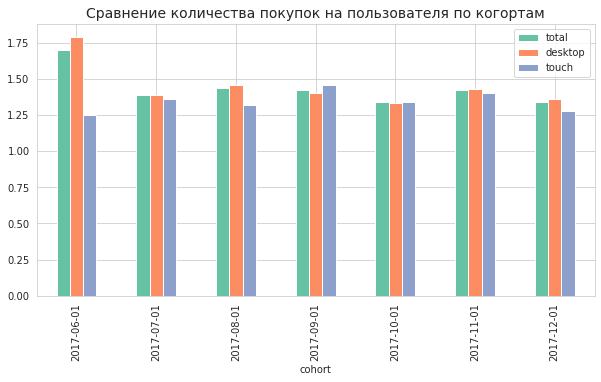

In [50]:
num_of_orders_period_by_device = pd.DataFrame({'cohort': num_of_orders_total_period.index, 
                   'total': num_of_orders_total_period.values,
                   'desktop': num_of_orders_desktop_period.values, 
                   'touch': num_of_orders_touch_period.values})
num_of_orders_period_by_device = num_of_orders_period_by_device.set_index('cohort')
num_of_orders_period_by_device.index = num_of_orders_period_by_device.index.astype('str')
num_of_orders_period_by_device
print('Средние:')
num_of_orders_period_by_device.mean().round(2)
_ = num_of_orders_period_by_device.plot(kind='bar', figsize=(10,5))
_ = plt.title('Сравнение количества покупок на пользователя по когортам', fontsize=14)

**В среднем на пользователя за 6 месяцев приходится 1,44 покупки, при этом среднее по повторным покупкам с декстопа выше, чем с мобильных (1,45 против 1,34)**. Сравнение по когортам показывает, что на июньской было больше всего повторных покупок, и в основном с декстопа, в на октябрьской, количество покупок с мобильных приблизилось к десктопным. 

Теперь посмотрим **по первым 5ти источникам**. Сначала построим когорты для всех, чтобы использовать позже.

In [51]:
cohorts_source_1 = build_cohorts(orders.query('first_source  == 1'))
cohorts_source_1.head(3)

cohorts_source_2 = build_cohorts(orders.query('first_source  == 2'))
cohorts_source_2.head(3)

cohorts_source_3 = build_cohorts(orders.query('first_source  == 3'))
cohorts_source_3.head(3)

cohorts_source_4 = build_cohorts(orders.query('first_source  == 4'))
cohorts_source_4.head(3)

cohorts_source_5 = build_cohorts(orders.query('first_source  == 5'))
cohorts_source_5.head(3)

cohorts_source_7 = build_cohorts(orders.query('first_source  == 7'))
cohorts_source_7.head(3)

cohorts_source_9 = build_cohorts(orders.query('first_source  == 9'))
cohorts_source_9.head(3)

cohorts_source_10 = build_cohorts(orders.query('first_source  == 10'))
cohorts_source_10.head(3)

,first_order_month,order_month,total_revenue,num_of_orders,num_of_buyers,cohort_lifetime,order_per_user
0,2017-06-01,2017-06-01,1378.70,268,190,0,1.410526
1,2017-06-01,2017-07-01,414.98,80,190,1,0.421053
2,2017-06-01,2017-08-01,419.43,87,190,2,0.457895


,first_order_month,order_month,total_revenue,num_of_orders,num_of_buyers,cohort_lifetime,order_per_user
0,2017-06-01,2017-06-01,1043.68,281,235,0,1.195745
1,2017-06-01,2017-07-01,115.54,17,235,1,0.072340
2,2017-06-01,2017-08-01,63.90,20,235,2,0.085106


,first_order_month,order_month,total_revenue,num_of_orders,num_of_buyers,cohort_lifetime,order_per_user
0,2017-06-01,2017-06-01,2804.34,704,638,0,1.103448
1,2017-06-01,2017-07-01,71.97,13,638,1,0.020376
2,2017-06-01,2017-08-01,118.93,21,638,2,0.032915


,first_order_month,order_month,total_revenue,num_of_orders,num_of_buyers,cohort_lifetime,order_per_user
0,2017-06-01,2017-06-01,1959.84,467,413,0,1.130751
1,2017-06-01,2017-07-01,16.66,7,413,1,0.016949
2,2017-06-01,2017-08-01,70.57,9,413,2,0.021792


,first_order_month,order_month,total_revenue,num_of_orders,num_of_buyers,cohort_lifetime,order_per_user
0,2017-06-01,2017-06-01,1898.89,447,384,0,1.164062
1,2017-06-01,2017-07-01,346.73,55,384,1,0.143229
2,2017-06-01,2017-08-01,172.53,30,384,2,0.078125


,first_order_month,order_month,total_revenue,num_of_orders,num_of_buyers,cohort_lifetime,order_per_user
0,2017-08-01,2017-08-01,1.22,1,1,0,1.0


,first_order_month,order_month,total_revenue,num_of_orders,num_of_buyers,cohort_lifetime,order_per_user
0,2017-06-01,2017-06-01,242.69,79,68,0,1.161765
1,2017-06-01,2017-07-01,4.88,2,68,1,0.029412
2,2017-06-01,2017-08-01,39.98,7,68,2,0.102941


,first_order_month,order_month,total_revenue,num_of_orders,num_of_buyers,cohort_lifetime,order_per_user
0,2017-06-01,2017-06-01,229.35,108,95,0,1.136842
1,2017-06-01,2017-07-01,11.06,3,95,1,0.031579
2,2017-06-01,2018-02-01,0.85,1,95,8,0.010526


Таблицы показывают, что на источник 7 пришелся только один заказ, соответственно, дальше мы его рассматривать не будет. 
Построим сводные таблицы и суммарное количество покупок на пользователя по когортам. Затем визуализируем.

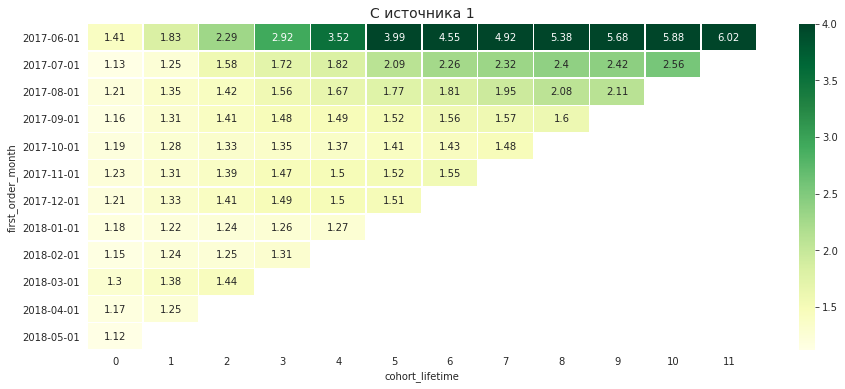

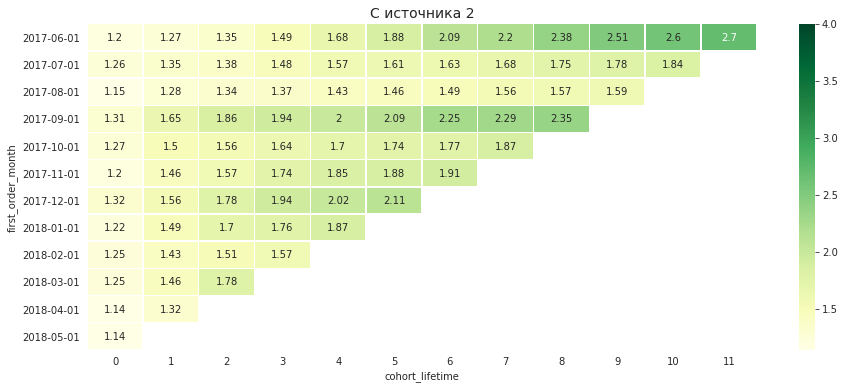

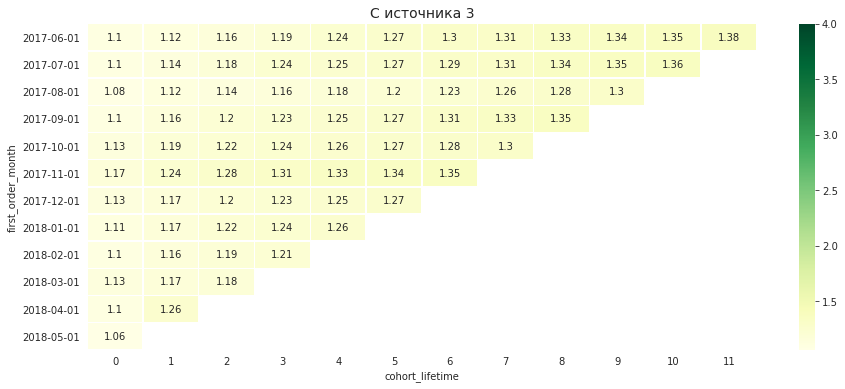

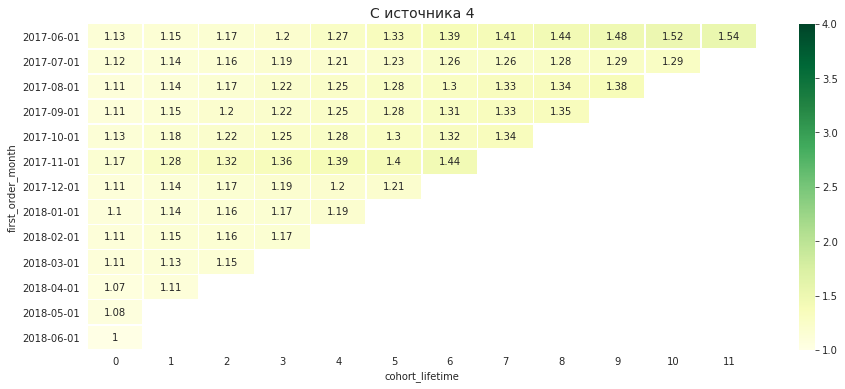

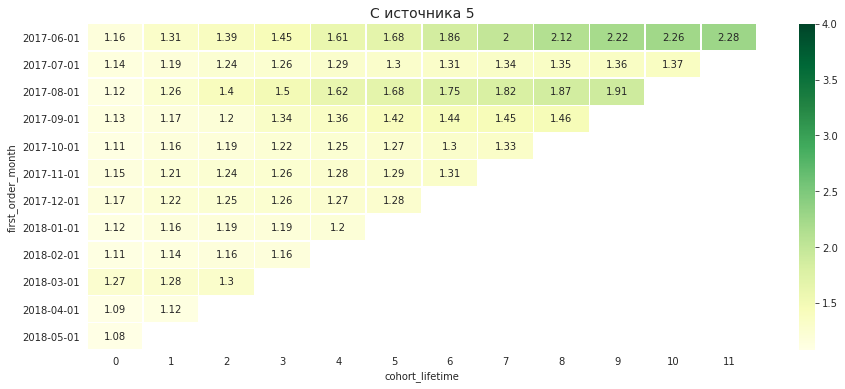

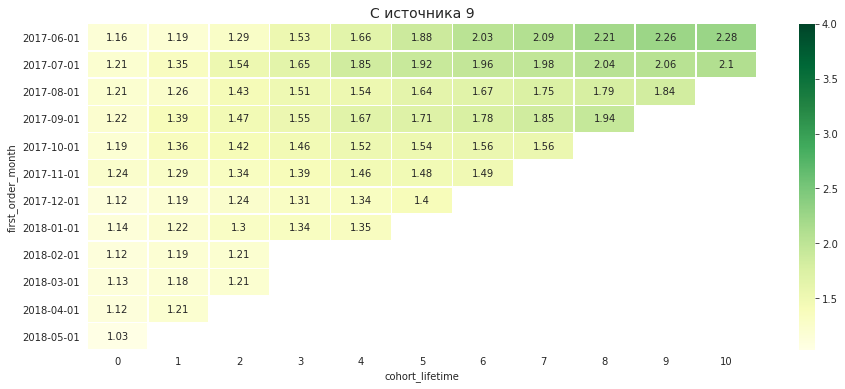

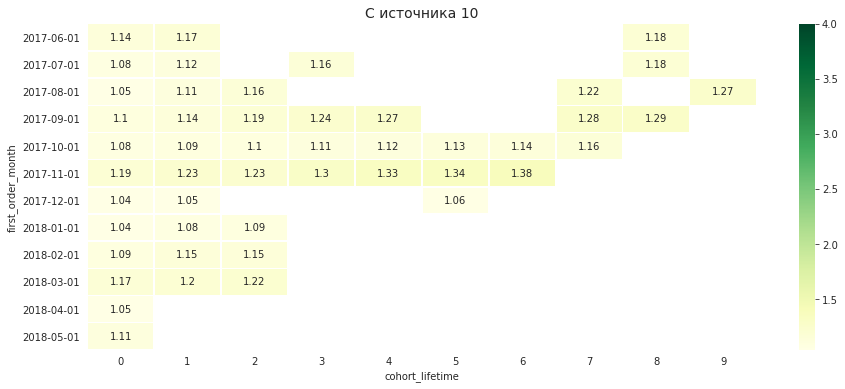

In [52]:
num_of_orders_source_1, num_of_orders_source_1_period = count_num_of_orders(cohorts_source_1)
plot_heatmap(num_of_orders_source_1, 'С источника 1', 4)

num_of_orders_source_2, num_of_orders_source_2_period = count_num_of_orders(cohorts_source_2)
plot_heatmap(num_of_orders_source_2, 'С источника 2', 4)

num_of_orders_source_3, num_of_orders_source_3_period = count_num_of_orders(cohorts_source_3)
plot_heatmap(num_of_orders_source_3, 'С источника 3', 4)

num_of_orders_source_4, num_of_orders_source_4_period = count_num_of_orders(cohorts_source_4)
plot_heatmap(num_of_orders_source_4, 'С источника 4', 4)

num_of_orders_source_5, num_of_orders_source_5_period = count_num_of_orders(cohorts_source_5)
plot_heatmap(num_of_orders_source_5, 'С источника 5', 4)

num_of_orders_source_9, num_of_orders_source_9_period = count_num_of_orders(cohorts_source_9)
plot_heatmap(num_of_orders_source_9, 'С источника 9', 4)

num_of_orders_source_10, num_of_orders_source_10_period = count_num_of_orders(cohorts_source_10)
plot_heatmap(num_of_orders_source_10, 'С источника 10', 4)

Снова соберем средние значения по периодам в отдельную таблицу. Выведем среднее и сравним остальное на графике для наглядности.

,total,1,2,3,4,5
cohort,,,,,,
2017-06-01,1.70,3.99,1.88,1.27,1.33,1.68
2017-07-01,1.39,2.09,1.61,1.27,1.23,1.30
2017-08-01,1.44,1.77,1.46,1.20,1.28,1.68
2017-09-01,1.42,1.52,2.09,1.27,1.28,1.42
2017-10-01,1.34,1.41,1.74,1.27,1.30,1.27
2017-11-01,1.42,1.52,1.88,1.34,1.40,1.29
2017-12-01,1.34,1.51,2.11,1.27,1.21,1.28


Средние:


total    1.44
1        1.97
2        1.82
3        1.27
4        1.29
5        1.42
dtype: float64

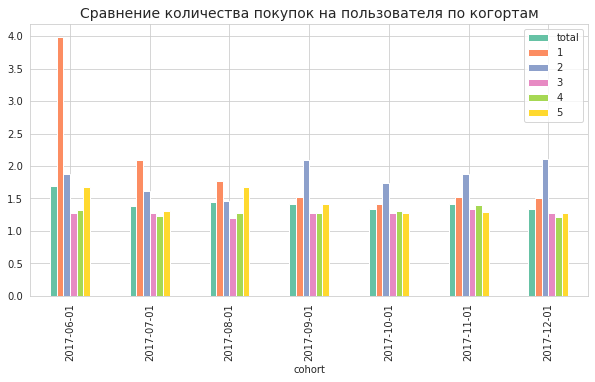

In [53]:
num_of_orders_period_by_source = pd.DataFrame({'cohort': num_of_orders_total_period.index, 
                   'total': num_of_orders_total_period.values,
                   '1': num_of_orders_source_1_period.values, 
                   '2': num_of_orders_source_2_period.values,
                   '3': num_of_orders_source_3_period.values,
                   '4': num_of_orders_source_4_period.values, 
                   '5': num_of_orders_source_5_period.values})
num_of_orders_period_by_source = num_of_orders_period_by_source.set_index('cohort')
num_of_orders_period_by_source.index = num_of_orders_period_by_source.index.astype('str')
num_of_orders_period_by_source
print('Средние:')
num_of_orders_period_by_source.mean().round(2)
_ = num_of_orders_period_by_source.plot(kind='bar', figsize=(10,5))
_ = plt.title('Сравнение количества покупок на пользователя по когортам', fontsize=14)
_ = plt.legend()

**В среднем большее количество повторных покупок приходится на источник 1 (1.97), за ним идут источник 2 (1.82) и 5 (1.42)**, и количество покупок с этих источников меняется в зависимости от когорты. Так, источник 1 лидировал на когортах июня, июля и августа, а затем уступил место источнику 2.
Источники 3 и 4 приносят стабильное количество покупок с когорты (около 1.3).

## Какой средний чек? <a id="step3.3"></a>

In [54]:
def find_avg_receipt(df, columns=None):
    avg_receipt=df.pivot_table(index='order_month', columns=columns, values='revenue', aggfunc='mean').round(2)
    return avg_receipt

Среднее: 4.84


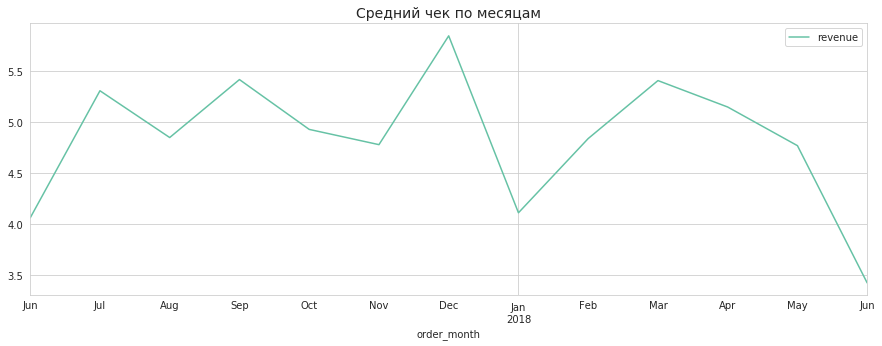

Среднее: first_device
desktop    4.98
touch      4.32
dtype: float64


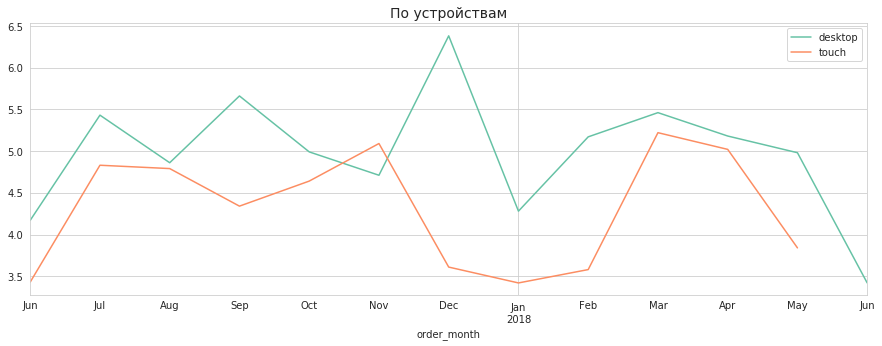

Среднее: first_source
1     6.00
2     6.95
3     4.24
4     4.37
5     5.25
7     1.22
9     3.54
10    2.95
dtype: float64


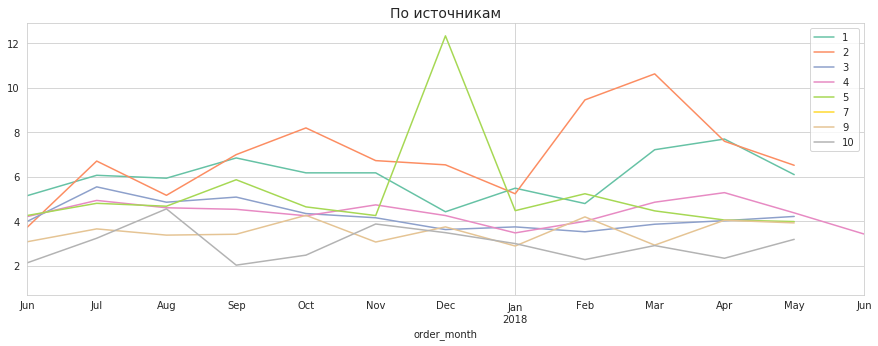

In [55]:
avg_receipt_total = find_avg_receipt(orders)
print('Среднее:', avg_receipt_total.revenue.mean().round(2))
plot_line(avg_receipt_total, 'Средний чек по месяцам')
plt.show()

avg_receipt_by_device = find_avg_receipt(orders, 'first_device')
print('Среднее:', avg_receipt_by_device.mean().round(2))
plot_line(avg_receipt_by_device, 'По устройствам')
plt.show()

avg_receipt_by_source = find_avg_receipt(orders, 'first_source')
print('Среднее:', avg_receipt_by_source.mean().round(2))
plot_line(avg_receipt_by_source, 'По источникам')
plt.show()

**Средний чек в месяц - 4.84 у.е.**

**С десктопа** средний чек **выше (4.98 у.е. против 4.32 у.е.)**, хотя график показывает, что тенденции изменения среднего чека не одинаковые по месяцам. Так, например, в сентябре и декабре 2017 года у десктопа были пики, а у мобильных устройств - провалы, а в ноябре, наоборот, средний чек мобильных превысил средний чек десктопа. 

Что касается **источников**, то самый **высокий чек у 2го источника (6.95 у.е.)**, который дал пики в октябре и марте. **Далее идет 1й (6.00 у.е.) и 5й (5.25 у.е.)**. У этих источников также большее количество покупок. Интересно, что средний чек источников 3 и 4, на которые приходится большая часть сессий, ниже среднего. То есть эти источники приводят много посетителей, но мало покупателей.   

## Сколько денег приносят? (LTV) <a id="step3.4"></a>

Посколько данных о маржинальности нет, посчитаем LTV от выручки (допустим, что margin rate=100%). Возьмем период за 6 месяцев, как было с количеством покупок. Напишем функцию для посчета ltv, которая выведет сводную таблицу и срез за 6 месяцев

In [56]:
def count_ltv(cohorts):
    cohorts['ltv'] = cohorts['total_revenue'] / cohorts['num_of_buyers']
    ltv = cohorts.pivot_table(index='first_order_month', columns='cohort_lifetime', values='ltv', aggfunc='mean')\
                 .cumsum(axis=1).round(2)
    period = ltv.iloc[:7, 5].copy()
    return ltv, period

**На всех данных и по устройствам**

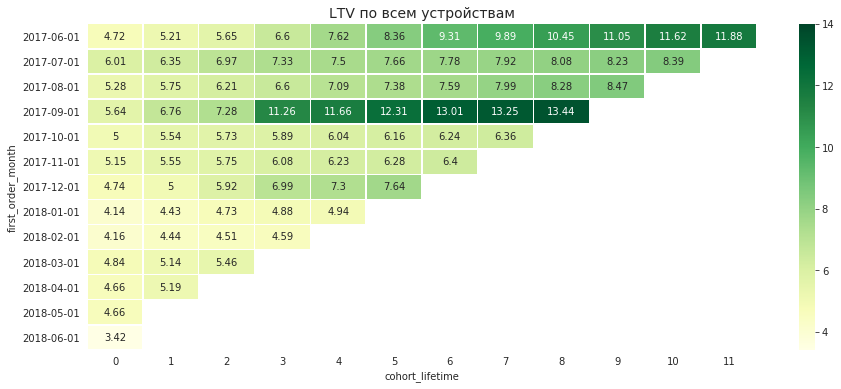

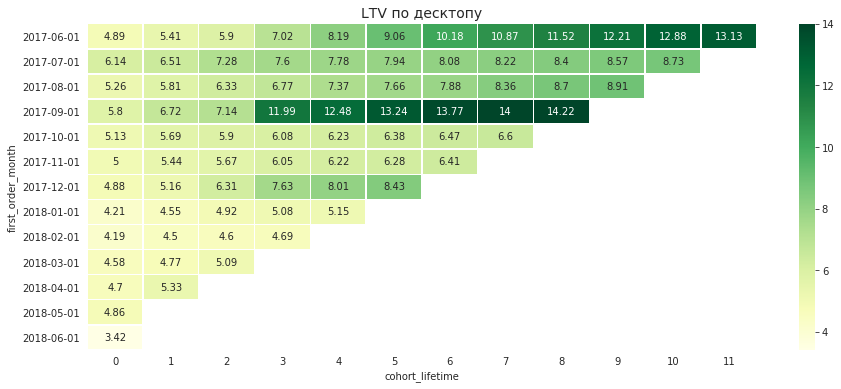

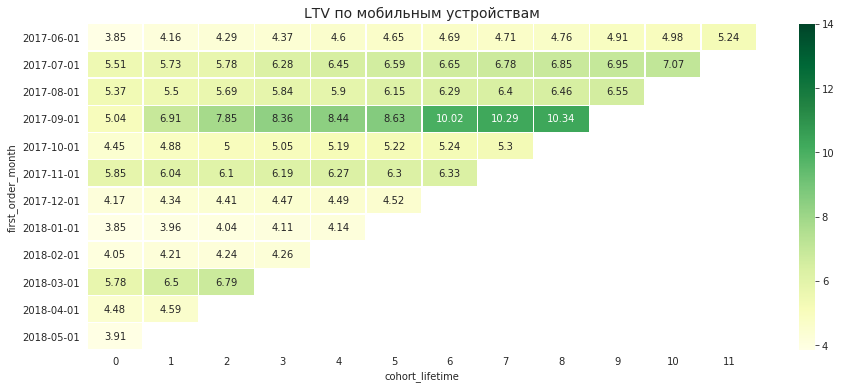

In [57]:
ltv_total, ltv_total_period = count_ltv(cohorts_total)
plot_heatmap(ltv_total, 'LTV по всем устройствам', 14)

ltv_desktop, ltv_desktop_period = count_ltv(cohorts_desktop)
plot_heatmap(ltv_desktop, 'LTV по десктопу', 14)

ltv_touch, ltv_touch_period = count_ltv(cohorts_touch)
plot_heatmap(ltv_touch, 'LTV по мобильным устройствам', 14)

Соберем средние значения по периодам в отдельную таблицу. Выведем среднее и сравним остальное на графике для наглядности.

,total,desktop,touch
cohort,,,
2017-06-01,8.36,9.06,4.65
2017-07-01,7.66,7.94,6.59
2017-08-01,7.38,7.66,6.15
2017-09-01,12.31,13.24,8.63
2017-10-01,6.16,6.38,5.22
2017-11-01,6.28,6.28,6.30
2017-12-01,7.64,8.43,4.52


Средние:


total      7.97
desktop    8.43
touch      6.01
dtype: float64

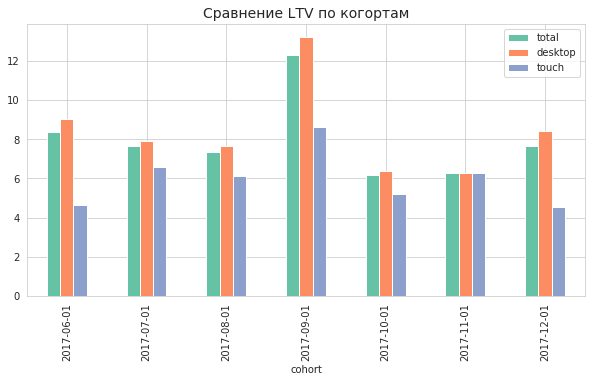

In [58]:
ltv_period_by_device = pd.DataFrame({'cohort': ltv_total_period.index, 
                   'total': ltv_total_period.values,
                   'desktop': ltv_desktop_period.values, 
                   'touch': ltv_touch_period.values})
ltv_period_by_device = ltv_period_by_device.set_index('cohort')
ltv_period_by_device.index = ltv_period_by_device.index.astype('str')
ltv_period_by_device
print('Средние:')
ltv_period_by_device.mean().round(2)
_ = ltv_period_by_device.plot(kind='bar', figsize=(10,5))
_ = plt.title('Сравнение LTV по когортам', fontsize=14)

**Один покупатель приносит в среднем 7.97 у.е. со всех своих покупок, при этом с декстопа приносят больше - 8.43 у.е, а с мобильных устройств - меньше - 6.01 у.е.** 

Также можно заметить, то больше всего принесла сентябрьская когорта (почти на 4 у.е больше среднего), что может быть связано с началом театрального сезона и тем, что люди активнее покупают билеты на предстоящий сезон (особенно учитывая, что в основном покупки происходят на первой сессии). Другая интересная деталь - ноябрьская когорта с мобильных принесла столько же, сколько с декстопа. Возможно, было какое-то событие, на которое было быстро и удобно совершить покупку с мобильного, и оно получило хорошую рекламу.

**По источникам**

Будем смотреть визуализацию также по первым пяти источникам, но таблицы построим по всем, чтобы использовать их для подсчета ROMI позже.

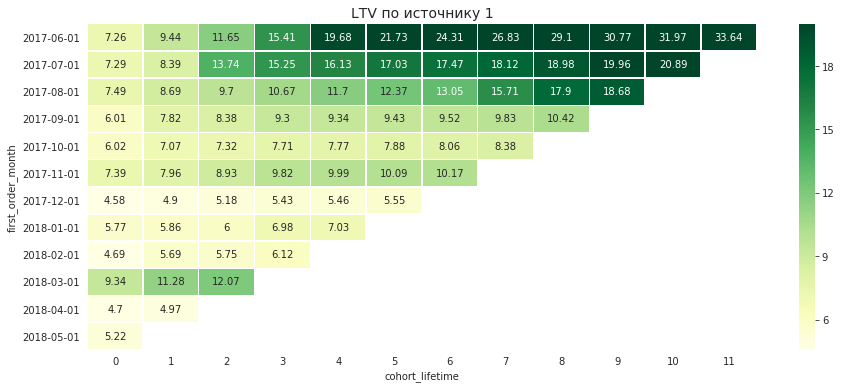

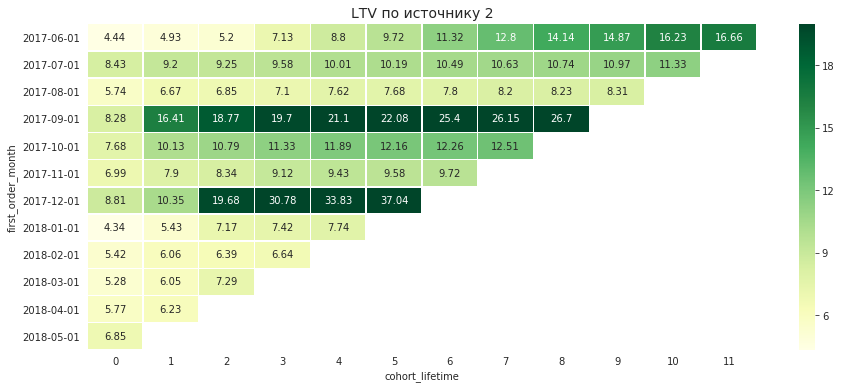

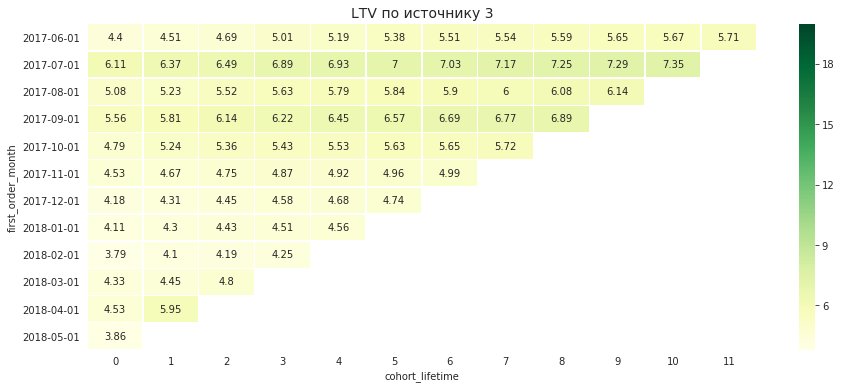

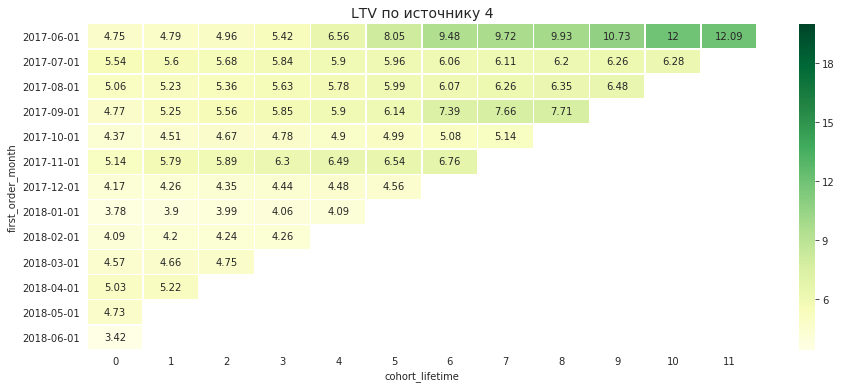

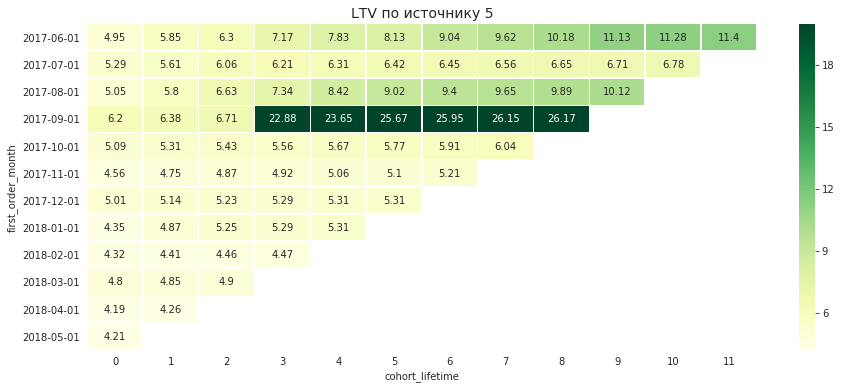

In [59]:
ltv_source_1, ltv_source_1_period = count_ltv(cohorts_source_1)
plot_heatmap(ltv_source_1, 'LTV по источнику 1', 20)

ltv_source_2, ltv_source_2_period = count_ltv(cohorts_source_2)
plot_heatmap(ltv_source_2, 'LTV по источнику 2', 20)

ltv_source_3, ltv_source_3_period = count_ltv(cohorts_source_3)
plot_heatmap(ltv_source_3, 'LTV по источнику 3', 20)

ltv_source_4, ltv_source_4_period = count_ltv(cohorts_source_4)
plot_heatmap(ltv_source_4, 'LTV по источнику 4', 20)

ltv_source_5, ltv_source_5_period = count_ltv(cohorts_source_5)
plot_heatmap(ltv_source_5, 'LTV по источнику 5', 20)

ltv_source_9, ltv_source_9_period = count_ltv(cohorts_source_9)

ltv_source_10, ltv_source_10_period = count_ltv(cohorts_source_10)

Снова соберем средние значения по периодам в отдельную таблицу. Выведем среднее и сравним остальное на графике для наглядности.

,total,1,2,3,4,5,9,10
cohort,,,,,,,,
2017-06-01,8.36,21.73,9.72,5.38,8.05,8.13,5.55,NaN
2017-07-01,7.66,17.03,10.19,7.00,5.96,6.42,6.17,NaN
2017-08-01,7.38,12.37,7.68,5.84,5.99,9.02,5.27,NaN
2017-09-01,12.31,9.43,22.08,6.57,6.14,25.67,7.48,NaN
2017-10-01,6.16,7.88,12.16,5.63,4.99,5.77,6.99,2.78
2017-11-01,6.28,10.09,9.58,4.96,6.54,5.10,4.51,5.03
2017-12-01,7.64,5.55,37.04,4.74,4.56,5.31,4.75,3.99


Средние:


total     7.97
1        12.01
2        15.49
3         5.73
4         6.03
5         9.35
9         5.82
10        3.93
dtype: float64

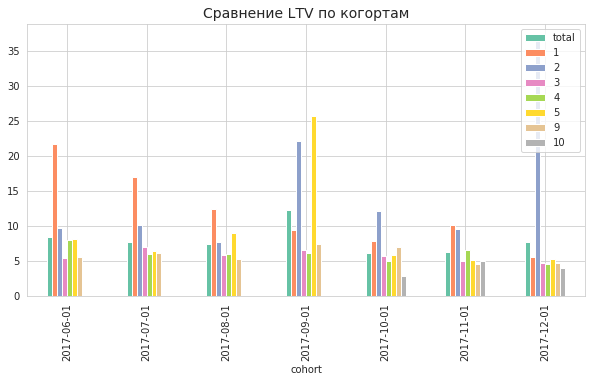

In [60]:
ltv_period_by_source = pd.DataFrame({'cohort': ltv_total_period.index, 
                   'total': ltv_total_period.values,
                   '1': ltv_source_1_period.values, 
                   '2': ltv_source_2_period.values,
                   '3': ltv_source_3_period.values,
                   '4': ltv_source_4_period.values, 
                   '5': ltv_source_5_period.values,
                   '9': ltv_source_9_period.values,
                   '10': ltv_source_10_period.values})
ltv_period_by_source = ltv_period_by_source.set_index('cohort')
ltv_period_by_source.index = ltv_period_by_source.index.astype('str')
ltv_period_by_source
print('Средние:')
ltv_by_source = ltv_period_by_source.mean().round(2)
ltv_by_source
_ = ltv_period_by_source.plot(kind='bar', figsize=(10,5))
_ = plt.title('Сравнение LTV по когортам', fontsize=14)

**Больше всего денег приносят покупатели, пришедшие с источника 2 - 15.49 у.е**, что почти в два раза выше среднего. График показывает, что лучше всего этот источник сработал с декабрьской когортой (37.04 у.е - больше, чем в пять раза выше среднего). Также этот источник хорошо сработал для сентябрьской когорты, почти в два раза превысив среднее. На втором месте - 1й источник (12.01 у.е) и затем идет 5й (9.35 у.е). 5й источник был особенно удачен для сентябрьской когорты, также превысив среднее в больше, чем два раза. 

**Меньше всего - с 3го источника.** Учитывая, что с него идет почти четверть всех визитов, но мало покупателей, возможно, он не совсем удачно работает и приводит аудиторию, которая не готова покупать. 

## Вывод по продажам <a id="step3.5"></a>

**Когда люди начинают покупать?**

60% людей начинают покупать *в течение первого часа после захода на страницу*, при этом *наиболее часто* встречающееся время - *через одну минуту*. 
Если смотреть *на промежутке до часа, время покупки от первого визита примерно одинаково с десктопа и с мобильных устройств*, а если рассматривать более длительный период времени, то уже со второго часа от первого визита с мобильных устройств в среднем требуется больше времени, чтобы совершить первую покупку. 
С источников 3, 4, 5 и 10 проходит меньше времени от первого визита до покупки, а с источников 1, 2 и 9 - как минимум в 10 раз больше, если сравнивать по медиане (22-35 против 240-720 мин). Однако стоит отметить, что, посколько время от первого визита до первой покупки имеет распределение Пуассона, медиана в данном случае главным образом дает только информацию о том, что есть покупки, которые произошли много позже первой сессии, и с мобильных таких покупок больше. 

*В 70% случаях покупка происходит на 1й сессии, а в 95% - не дольше 3й.*

**Сколько раз покупают за период?**

Соединение таблиц по посещениям и по продажам показало, что только для 70% заказов есть соответствующая им сессия. При этом *83% заказов было сделано с десктопа, 17% - с мобильных устройств*. Соотношение сдвинулось на 8% в сторону декстопа по сравнению с сессиями. По источникам распределение похоже на сессии. Суммарно источники 7, 9 и 10 принесли только около 10% продаж, поэтому было решено их в дальнейшем не рассматривать, учитывая тот факт, что на них также приходится малое количество сессий 

*В среднем на пользователя за 6 месяцев приходится 1,44 покупки*, при этом среднее по повторным покупкам *с декстопа выше*, чем с мобильных (1,45 против 1,34). В среднем *большее количество повторных покупок* приходится на *источник 1 (1.97), за ним идут источник 2 (1.82) и 5 (1.42)*. Источники 3 и 4 приносят стабильное количество покупок с когорты (около 1.3).

**Какой средний чек?**

Средний чек в месяц - *4.84 у.е.*

*С десктопа средний чек выше* (4.98 у.е. против 4.32 у.е.), хотя график показывает, что тенденции изменения среднего чека не одинаковые по месяцам. 
Что касается источников, то *самый высокий чек у 2го источника (6.95 у.е.)*, который дал пики в октябре и марте. Далее идет 1й (6.00 у.е.) и 5й (5.25 у.е.). Средний чек источников 3 и 4, на которые приходится большая часть сессий, ниже среднего. То есть эти источники приводят много посетителей, но мало покупателей.

**Сколько денег приносят? (LTV)**
*Один покупатель* приносит в среднем *7.97 у.е. со всех своих покупок*, при этом *с декстопа приносят больше* - 8.43 у.е, а с мобильных устройств - меньше - 6.01 у.е.
*Больше всего денег приносят покупатели*, пришедшие *с источника 2* - 15.49 у.е, что почти в два раза выше среднего. На втором месте - 1й источник (12.01 у.е) и затем идет 5й (9.35  у.е).

Меньше всего - с 3го источника. Учитывая, что с него идет почти четверть всех визитов, но мало покупателей, возможно, он не совсем удачно работает и приводит аудиторию, которая не готова покупать.

# Шаг 4. Маркетинг <a id="step4"></a>

Добавим столбец с месяцем (cost_month)

In [61]:
costs['cost_month'] = costs['cost_date'].astype('datetime64[M]')

## Сколько денег потратили? <a id="step4.1"></a>

#### Всего

In [62]:
total_costs = costs.cost_amount.sum()
print('Все расходы:', total_costs)

Все расходы: 329131.62


Сравним с общим доходом.

In [63]:
total_revenue = orders.revenue.sum()
print('Все доходы', total_revenue)
(total_revenue - total_costs).round(2)

Все доходы 252057.2


-77074.42

Получается, суммарно по всем данным доходы еще полностью не окупили расходы на маркетинг. 

#### На каждый источник

,cost_amount
source_id,
1,20833.27
2,42806.04
3,141321.63
4,61073.60
5,51757.10
9,5517.49
10,5822.49


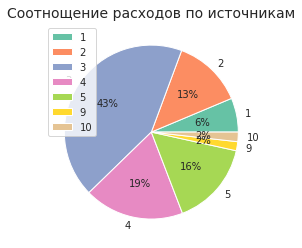

In [64]:
costs_by_source = costs.groupby('source_id')[['cost_amount']].sum()
costs_by_source
plot_pie(costs_by_source, 'Соотнощение расходов по источникам')

Немногим меньше половины бюджеты потратили на источник 3, который, как показал анализ выше, приносит меньше продаж и меньше денег суммарно по покупателю. Еще примерно 20% расходов пришлось на 4й источник, с которым такая же ситуация, как и с 3м. Ожидаемо меньше всего денег было потрачено на источники 9 и 10.  

#### По времени

Сгруппируем по месяцам и посчитаем среднее в месяц. А потом построим график, сгруппировав по неделя, что дамт немного больше детализации. 

Среднее в месяц:


27427.63

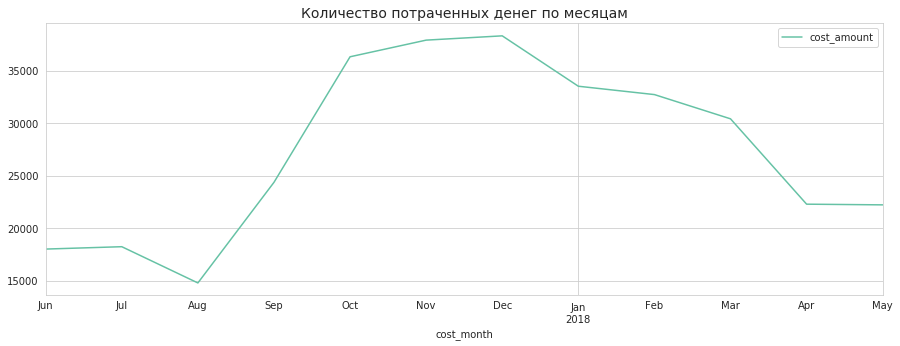

In [65]:
print('Среднее в месяц:')
monthly_costs = costs.groupby('cost_month').cost_amount.sum()
monthly_costs.mean().round(2)
plot_line(monthly_costs, 'Количество потраченных денег по месяцам')

Посмотрим еще соотношение по источникам

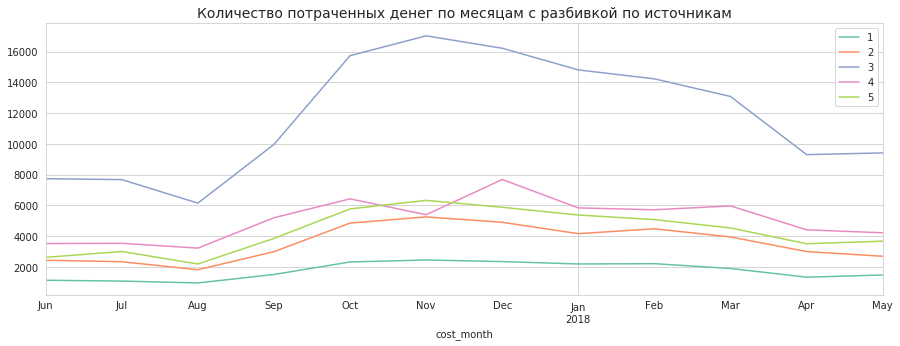

In [66]:
plot_line(costs.query('source_id in (1,2,3,4,5)')\
               .pivot_table(index='cost_month', columns='source_id', values='cost_amount', aggfunc='sum'),
               'Количество потраченных денег по месяцам с разбивкой по источникам')

**Всего потратили 329131 у.е.**, что в 1.3 раза больше дохода со всех продаж. Это может означать, что не на всех когортах еще окупились затраты на источники. Надо смотреть подробнее.

**В среднем в месяц уходит 27427.63 у.е.**, из них 43% на источник 3 и 19% - на источник 4, которые приносят продажи и LTV ниже среднего. 

Начиная **с августа растет количество затрачиваемых денег на источники, и больше всего тратится примерно с октября по март, при этом пик - в ноябре**. В то же время, в 1й источник вложения не так сильно меняются, как в 3й. Возможно, маркетологи знают, что первый источник работает стабильно, и ищут способы заставить 3й хорошо работать. 

## Сколько стоило привлечение одного покупателя из каждого источника? (CAC) <a id="step4.2"></a>

Найдем количество расходов в месяц (monthly_costs)

In [67]:
monthly_costs = costs.groupby('cost_month').cost_amount.sum()
monthly_costs

cost_month
2017-06-01    18015.00
2017-07-01    18240.59
2017-08-01    14790.54
2017-09-01    24368.91
2017-10-01    36322.88
2017-11-01    37907.88
2017-12-01    38315.35
2018-01-01    33518.52
2018-02-01    32723.03
2018-03-01    30415.27
2018-04-01    22289.38
2018-05-01    22224.27
Name: cost_amount, dtype: float64

На основе таблицы orders по каждому источнику посчитаем суммарное количество доходов (total_revenue), количество покупателей (num_of_buyers), расходов (cost_amount) и стоимость привлечение одного покупателя (cac). 

In [68]:
orders_costs = orders.groupby('first_source').agg({'revenue':'sum', 'uid':'nunique'})
orders_costs.columns = ['total_revenue', 'num_of_buyers']
orders_costs = orders_costs.join(costs_by_source)

orders_costs['cac'] = (orders_costs.cost_amount / orders_costs.num_of_buyers).round(2)
orders_costs

,total_revenue,num_of_buyers,cost_amount,cac
first_source,,,,
1,31090.55,2899,20833.27,7.19
2,46923.61,3506,42806.04,12.21
3,54511.24,10473,141321.63,13.49
4,56696.83,10296,61073.60,5.93
5,52624.02,6931,51757.10,7.47
7,1.22,1,NaN,NaN
9,5759.40,1088,5517.49,5.07
10,4450.33,1329,5822.49,4.38


In [69]:
print('Средняя стоимость привлечения одного покупателя', orders_costs.loc[:5, 'cac'].mean().round(2))

Средняя стоимость привлечения одного покупателя 9.26


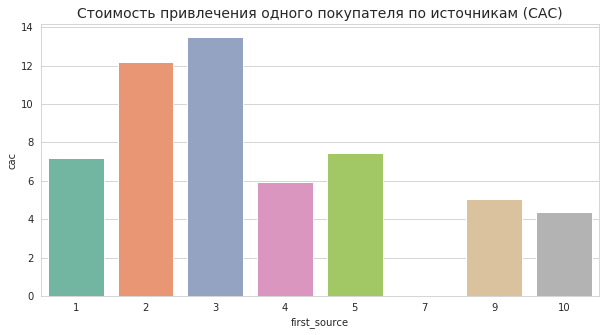

In [70]:
_ = plt.figure(figsize=(10,5))
_ = sns.barplot(data=orders_costs, x=orders_costs.index, y='cac')
_ = plt.title('Стоимость привлечения одного покупателя по источникам (CAC)', fontsize=14)

Средняя стоимость привлечения одного покупателя - 9.26 у.е., при этом дороже всего привлечение с источника 3, того самого, который приносит продажи ниже средних. 

## На сколько окупились расходы? (ROMI) <a id="step4.3"></a>

Преобразуем полученные раннее средние LTV по источникам в датафрейм, чтобы присоединить его к таблице orders_costs.

In [71]:
ltv = pd.DataFrame({'first_source':ltv_by_source[1:].index, 'ltv_by_source':ltv_by_source[1:].values})
ltv['first_source'] = ltv['first_source'].astype('int')
ltv = ltv.set_index('first_source')
ltv

orders_costs = orders_costs.merge(ltv, on='first_source')
orders_costs

,ltv_by_source
first_source,
1,12.01
2,15.49
3,5.73
4,6.03
5,9.35
9,5.82
10,3.93


,total_revenue,num_of_buyers,cost_amount,cac,ltv_by_source
first_source,,,,,
1,31090.55,2899,20833.27,7.19,12.01
2,46923.61,3506,42806.04,12.21,15.49
3,54511.24,10473,141321.63,13.49,5.73
4,56696.83,10296,61073.60,5.93,6.03
5,52624.02,6931,51757.10,7.47,9.35
9,5759.40,1088,5517.49,5.07,5.82
10,4450.33,1329,5822.49,4.38,3.93


Посчитаем ROMI, проверим и выведем среднее. Визуализируем, обозначив точку окупаемости в 1 (100%).

In [72]:
orders_costs['romi'] = (orders_costs.ltv_by_source / orders_costs.cac).round(2)
orders_costs

print('Средняя окупаемость рекламных источников:', orders_costs.romi.mean().round(2))

,total_revenue,num_of_buyers,cost_amount,cac,ltv_by_source,romi
first_source,,,,,,
1,31090.55,2899,20833.27,7.19,12.01,1.67
2,46923.61,3506,42806.04,12.21,15.49,1.27
3,54511.24,10473,141321.63,13.49,5.73,0.42
4,56696.83,10296,61073.60,5.93,6.03,1.02
5,52624.02,6931,51757.10,7.47,9.35,1.25
9,5759.40,1088,5517.49,5.07,5.82,1.15
10,4450.33,1329,5822.49,4.38,3.93,0.90


Средняя окупаемость рекламных источников: 1.1


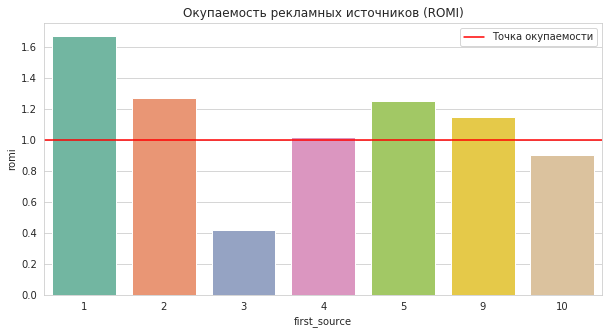

In [73]:
_ = plt.figure(figsize=(10,5))
g = sns.barplot(data=orders_costs, x=orders_costs.index, y='romi')
_ = g.axhline(1, color='red', label='Точка окупаемости')
_ = plt.title('Окупаемость рекламных источников (ROMI)')
_ = plt.legend()

**Лучше всего окупился 1й источник (1.67).** Далее - 2й, 5й (примерно одинакого 1.27 и 1.25) и 9й (1.15). 4й только-только пересек линию окупаемости (1.02). **3й  - самый провальный** (не окупил даже половины вложенного - **0.42**)

Сделаем функцию для подсчета ROMI по определенной когорте. Мы ее используем один раз, но гипотетически ее также можно было бы использовать на разных когортах, как было выше. 

In [74]:
def count_romi(cohorts):
    cohorts = pd.merge(cohorts, monthly_costs, left_on='first_order_month', right_on='cost_month')
    cohorts['cac'] = cohorts.cost_amount / cohorts.num_of_buyers
    cohorts['romi'] = cohorts.ltv / cohorts.cac
    romi = cohorts.pivot_table(index='first_order_month', columns='cohort_lifetime', values='romi', aggfunc='mean')\
    .cumsum(axis=1).round(2)
    return romi

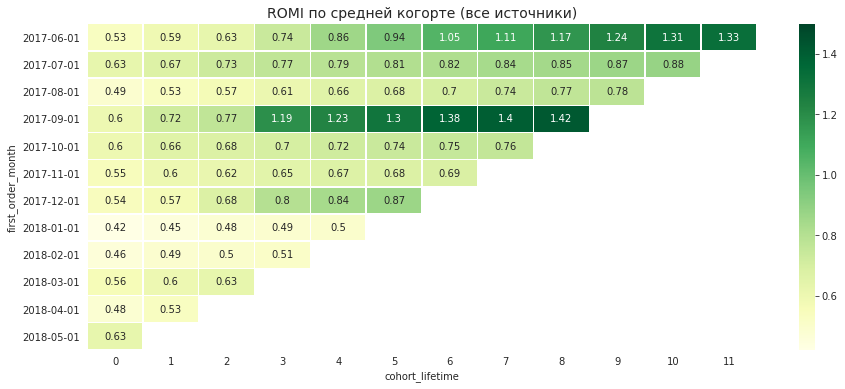

In [75]:
romi_total = count_romi(cohorts_total)
plot_heatmap(romi_total, 'ROMI по средней когорте (все источники)', 1.5)

Тепловая карта показывает, что по имеющимся данным окупились только две когорты - июнькая и сентябрьская. В июне-июле 2018 могли бы окупиться июльская и декабрьская. 

## Вывод по маркетингу <a id="step4.5"></a>

**Все расходы**: *329131.62 у.е*. Расходы превысили доходы на 77074.42 у.е.

Среднее **в месяц**: *27427.63 у.е.*, из них 43% на источник, 19% - на источник 4, 16% - на 5й, 13% - на 2й, 6% - на 1й и 4% суммарно на 9й и 10й. 

**По времени**: начиная с августа растет количество затрачиваемых денег на источники, и *больше всего тратится примерно с октября по март, при этом пик - в ноябре*. 

**Средняя стоимость привлечения одного покупателя** - *9.26 у.е.*, при этом дороже всего привлечение с источника 3, того самого, который приносит продажи ниже средних.

**Окупаемость**
*Лучше всего окупился 1й источник (1.67)*, хотя на него пришлось всего 6% бюджета. *Далее - 2й, 5й (примерно одинакого 1.27 и 1.25)* и 9й (1.15). 4й только-только пересек линию окупаемости (1.02). *3й - самый провальный* (не окупил даже половины вложенного - 0.42 при том, что на него было потрачено 43% бюджета)
Тепловая карта показывает, что по имеющимся данным *окупились только две когорты* - июнькая и сентябрьская. В июне-июле 2018 могли бы окупиться июльская и декабрьская. 

# Шаг 5. Общие выводы <a id="step5"></a>

Были проанализированы данные от Яндекс.Афиши с июня 2017 по конец мая 2018 года:
- лог сервера с данными о посещениях сайта Яндекс.Афиши,
- выгрузка всех заказов за этот период,
- статистика рекламных расходов.

Можно сделать следующие выводы.

В целом на десктоп приходится в среднем 70% сессий и 80% продаж.

### Продукт

**Среднее количество посетителей в день:  907, в неделю: 5621, в месяц: 23228** (71%/29% - десктоп/мобильные устройства). Можно предположить, что с компьютера удобнее смотреть схему расположения мест в зале и выбирать подходящие. Видна сезонность - больше посещений с сентября по март, меньше летом. Большее количество посетителей приходит с рекламных источников 4 (30%), 3 (26%) и 5 (19%), а наименьшее - с 10 (3%) и 9 (4%). 5й источник иногда дает пики там, где два лидирующих, наоборот, приносят меньше посетителей.

**В день среднем 1003 сессии, на одного посетителя - в среднем одна сессия в день.**, (73%/27% - декстоп/мобильные устройства). К наибольшему количеству сессий приводят рекламные источники 4, 3 и 5 - 28%, 24% и 19%* соответственно. 

**95% сессий не дольше 38 минут, при этом медиана равна 300 сек (5 мин)**. С десктопа пользователи сидят почти в два раза дольше, чем с мобильных устройств (6 мин против 3 мин по медиане). Лидирует по продолжительности сессии 1й источник, который только 5й по количеству сессий, - посетители задерживаются в среднем на 10 минут. После него идет 2й источник - 7 мин. Источники, которые привлекают больше всего посетителей (4, 3, 5), приводят к более короткой сессии (5 мин против 6ти по медиане). 

**В среднем коэффициент удержания пользователей составляет 6.5% на 1м месяце жизни когорты и затем падает до примерно 3.7% на 8м**, при этом у декстопа он стабильно выше, чем у мобильных устройств, и у тех, кто пришел с 2го (16.7%) и 1го (14.5%) источников, что выше среднего. При этом на эти источники приходится только около 11% и 7% сессий соответственно. 


### Продажи

**60% людей начинают покупать в течение первого часа после захода на страницу и чаще всего - через одну минуту**. На промежутке до часа, время покупки от первого визита примерно одинаково с десктопа и с мобильных устройств, но со второго часа от первого визита с мобильных устройств в среднем требуется больше времени, чтобы совершить первую покупку. С источников 3, 4, 5 и 10 проходит меньше времени от первого визита до покупки, а с источников 1, 2 и 9 - значительно больше. Однако стоит отметить, что, посколько время от первого визита до первой покупки имеет распределение Пуассона, медиана в данном случае главным образом дает только информацию о том, что есть покупки, которые произошли много позже первой сессии, и с мобильных таких покупок больше.

**В 70% случаях покупка происходит на 1й сессии, а в 95% - не дольше 3й.**

**В среднем на пользователя за 6 месяцев приходится 1,44 покупки** (с декстопа выше, чем с мобильных (1,45 против 1,34)). Большее количество повторных покупок приходится на источник 1 (1.97), за ним идут источник 2 (1.82) и 5 (1.42). Источники 3 и 4 приносят стабильное количество покупок с когорты (около 1.3).

**Средний чек в месяц - 4.84 у.е.** (с десктопа выше (4.98 у.е. против 4.32 у.е.)). Что касается источников, то самый высокий чек у 2го источника (6.95 у.е.), который дал пики в октябре и марте. Далее идет 1й (6.00 у.е.) и 5й (5.25 у.е.). Средний чек источников 3 и 4, на которые приходится большая часть сессий, ниже среднего. То есть эти источники приводят много посетителей, но мало покупателей.

**Один покупатель приносит в среднем 7.97 у.е. со всех своих покупок**,(с декстопа приносят больше - 8.43 у.е против 6.01 у.е.) Больше всего денег приносят покупатели, пришедшие с источника 2 - 15.49 у.е, что почти в два раза выше среднего. На втором месте - 1й источник (12.01 у.е) и затем идет 5й (9.35 у.е). Меньше всего - с 3го источника. Учитывая, что с него идет почти четверть всех визитов, но мало покупателей, возможно, он не совсем удачно работает и приводит аудиторию, которая не готова покупать.

### Маркетинг
**Все расходы: 329131.62 у.е.** Расходы превысили доходы на 77074.42 у.е.

**Среднее в месяц: 27427.63 у.е.**, из них 43% на источник, 19% - на источник 4, 16% - на 5й, 13% - на 2й, 6% - на 1й и 4% суммарно на 9й и 10й.

**По времени**: начиная с августа растет количество затрачиваемых денег на источники, и больше всего тратится примерно с октября по март, при этом пик - в ноябре.

**Средняя стоимость привлечения одного покупателя - 9.26 у.е.**, при этом дороже всего привлечение с источника 3, того самого, который приносит продажи ниже средних.

**Окупаемость**: лучше всего окупился **1й источник** (1.67), хотя на него пришлось всего 6% бюджета. Далее - 2й, 5й (примерно одинакого 1.27 и 1.25) и 9й (1.15). 4й только-только пересек линию окупаемости (1.02). 3й - самый провальный (не окупил даже половины вложенного - 0.42 при том, что на него было потрачено 43% бюджета) Тепловая карта показывает, что по имеющимся данным окупились только две когорты - июнькая и сентябрьская. В июне-июле 2018 могли бы окупиться июльская и декабрьская.

### Куда и сколько им стоит вкладывать денег?
Ориентируясь на ROMI и средний чек, можно порекомендовать перераспределить бюджет с источников 3 и 4 на источники 1, 2 и 5, которые окупаются и приносят больше продаж. Хотя 3й и 4й приносят стабильное количество покупок на когорту, это все недорогие покупки, так как эти пользователи суммарно приносят доход ниже среднего. Кроме того, они не окупаются, особенно 3й (принес только 42% от вложенного).

Хотя на 5й источник уже приходится такой же процент сессий, что на 1й и 2й, у 1го и 2го - более длинные сессии и больший коэффициент удержания. Судя по всему потому, что люди приходят с определенной целью и тратят время, чтобы рассмотреть возможные варианты (билетов). 2й источник дал несколько пиков по продажам, возможно, он хорошо работает для определенных мероприятий.  